# 社群媒體分析期中報告：PTT八卦板的高端疫苗議題分析
- 第七組
- 組員：M092040020 陳佳伶、M092040013 顏廷諭、B074020058 曾天鈞
- 指導老師：黃三益 教授 & 助教團隊

### 主要分析PTT八卦板上高端疫苗的相關討論情形。本次主要針對以下面向：
1. 對高端疫苗的各事件討論大概出現在哪些時間點，話題高峰在哪裡？
2. 正面和負面的討論內容各是什麼，有沒有時間點上的差異？
3. 正面和負面討論的情緒分數大約多少？
4. 比較jieba和Snow NLP在情緒分析上的差異
5. n-gram上的分類情形

## 大綱
+ 0. 研究背景、動機與目的
+ 1. 載入套件
+ 2. 資料描述＆資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 與 Snow NLP 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量折線圖
    + 3.4 正負向情緒分數比例折線圖
    + 3.5 文字雲
    + 3.6 情緒代表字
    + 3.7 歸類正負面文章
    + 3.8 情緒關鍵字 
+ 4. Snow NLP 情緒分析
    + 4.1 平均情緒分數時間序列圖
    + 4.2 特定事件日的正負向情緒聲量與用字
+ 5. N-gram
    + 5.1 根據不同時期建立Ngram預測模型並且 Bigram視覺化 

## 0. 研究背景、動機與目的
## 研究背景：
+ 新冠肺炎引發的全球大流行，事發到現在已經快兩年了，它是由嚴重急性呼吸道症候群冠狀病毒2型（SARS-CoV-2）導致的嚴重特殊傳染性肺炎（COVID-19）。疾病在2019年末於中華人民共和國湖北省武漢市首次被發現，隨後在2020年初迅速擴散至全球多國。截至2021年11月28日，全球已累計報告逾2.61億例確診個案，其中逾519.8萬人死亡，是人類歷史上大規模流行病之一。全球初步修正病死率約為2.9%。

+ 世界衛生組織等眾多專家認為製作和廣泛對人類施打新冠疫苗是目前對抗肺炎的措施，因此各國生物製劑單位紛紛開始研究，而臺灣也有兩家生物製藥公司：高端和聯亞投入研發。

## 研究動機與目的：
+ 高端疫苗為臺灣首支在2021年7月18日取得衛福部食藥署的緊急使用授權，核准專案製造的國產疫苗。
　　
+ 早從今年5月30日與衛福部疾管署完成的500萬劑高端新冠肺炎疫苗採購案，到8月16日開放接種的線上預約，再到現今(11月初)高端疫苗尚未受到國際認可，網友搞笑說著臺灣是四劑帝國；高端疫苗在PTT上一直是熱門的討論話題，讓我們好奇PTT在每個階段對於高端疫苗的評價，能否區分出有哪些特定的族群或時期，並透過資料探索、分析到其他的現象。

## 1. 載入套件
下面列出在本次報告中我們所使用到的相關套件:
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- datetime: 時間處理工具。
- wordcloud: 文字雲繪圖工具。
- SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等。
- matplotlib: 繪圖工具。
- collections: 提供額外的數據類型。
- networkx: 網絡圖建構、繪製工具。

In [1]:
# 確認當前工作目錄
%pwd

'C:\\Users\\bppas\\Desktop\\Sun Yat sen university\\社群媒體分析\\Mid_project'

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
from snownlp import SnowNLP
from collections import Counter, namedtuple
from nltk import FreqDist
from nltk import ngrams
import networkx as nx

In [3]:
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使中文能正常顯示

## 2. 資料描述＆資料前處理
從網路或twitter api取得的原始資料可能包含雜訊（多餘的空白、html標籤、網址等），在進行斷詞處理前應先進行資料清理。

### 2.1 基本資料介紹
- 資料來源: 文字分析平台收集PTT Gossip版2020-02-01 ~ 2021-11-19 所有文章
- 資料集： `raw_data/covid_articleMetaData.csv`
- 關鍵字：高端、高端疫苗、國產疫苗、臺灣疫苗、台灣疫苗
- 資料時間：2020-02-01 ~ 2021-11-19
- 情緒字典：正負向字典採用NTUSD(台大)情緒字典。
- 斷詞字典：自定義7個項目(高端疫苗 10000,國產疫苗 10000,臺灣疫苗 10000,台灣疫苗 10000,新冠疫苗 10000,武漢疫苗 10000,疫苗1000)。

In [4]:
#匯入資料
MetaData = pd.read_csv('./raw_data/covid_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/covid_articleReviews.csv', encoding='UTF-8')

In [5]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 27599 篇文章


artTitle     artDate   artTime  \
0        [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
1  [問卦]第一個做出武漢肺炎疫苗的會是哪國？  2020/02/01  21:07:51   
2  Re:[爆卦]武漢肺炎新藥直接3期臨床實驗  2020/02/01  23:43:03   

                                              artUrl    artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1580620433....     gerychen  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1580629746....    Cetuximab  Gossiping   

   commentNum  push  boo                                           sentence  
0          72    37    8  如題\n\n來日本生活一陣子了\n\n發現他們很多地方整體規劃的都比台灣好\n\n而且他們也...  
1          35    15    4  餓死抬頭\n\n以現今各國的醫療實力來說\n比較有可能製造出武漢疫苗抗體的會是哪個國家R？\...  
2          12     6    0  首先是Remdesivir這藥物之前已經有非臨床（non-clinical study)試驗...

In [6]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(3)

共有 1940467 個留言


artTitle     artDate   artTime  \
0  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
1  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
2  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   

                                              artUrl    artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   

     cmtPoster cmtStatus                    cmtDate            cmtContent  
0      halusai         推  2020-02-01 17:16:00+00:00  :人家上海北京也說比台灣先進啊現在呵XD  
1  lavendersea         推  2020-02-01 17:16:00+00:00                 :西化太慢  
2    mtyk10100         →  2020-02-01 17:16:00+00:00             :上個世紀發展的好

In [7]:
# 再篩一次文章
keywords = ['高端','高端疫苗','國產疫苗','臺灣疫苗','台灣疫苗']
toMatch = '|'.join(keywords)

In [8]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(27578, 10)


In [9]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [10]:
print(Reviews.shape)
Reviews.head(3)

(1939946, 10)


artTitle     artDate   artTime  \
0  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
1  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
2  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   

                                              artUrl    artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   

   commentNum  push  boo            cmtContent  
0          72    37    8  :人家上海北京也說比台灣先進啊現在呵XD  
1          72    37    8                 :西化太慢  
2          72    37    8             :上個世紀發展的好

### 2.2 資料清理  
- 去除NA值
- 去除不是中文的字詞
- 移除與高端疫苗不相關的貼文

In [11]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [12]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [13]:
MetaData.head(3)

artTitle     artDate   artTime  \
0        [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
1  [問卦]第一個做出武漢肺炎疫苗的會是哪國？  2020/02/01  21:07:51   
2  Re:[爆卦]武漢肺炎新藥直接3期臨床實驗  2020/02/01  23:43:03   

                                              artUrl    artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1580620433....     gerychen  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1580629746....    Cetuximab  Gossiping   

   commentNum  push  boo                                           sentence  
0          72    37    8  如題來日本生活一陣子了發現他們很多地方整體規劃的都比台灣好而且他們也會有一些創意發明讓人覺得...  
1          35    15    4  餓死抬頭以現今各國的醫療實力來說比較有可能製造出武漢疫苗抗體的會是哪個國家我覺得比較有可能是...  
2          12     6    0  首先是這藥物之前已經有非臨床試驗資在料目前登記的臨床試驗為針對伊波拉的期試驗推測這藥物在人體...

In [14]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
Reviews.head(3)

artTitle     artDate   artTime  \
0  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
1  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   
2  [問卦]為什麼台灣比日本落後？  2020/02/01  09:15:37   

                                              artUrl    artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1580577699....  anger312143  Gossiping   

   commentNum  push  boo         cmtContent  
0          72    37    8  人家上海北京也說比台灣先進啊現在呵  
1          72    37    8               西化太慢  
2          72    37    8           上個世紀發展的好

In [15]:
#轉換日期格式 for MetaData
MetaData['artDate'] = pd.to_datetime(MetaData['artDate'], format="%Y/%m/%d")

Reviews['artDate'] = pd.to_datetime(Reviews['artDate'], format="%Y/%m/%d")

### 移除與高端疫苗不相關的貼文

In [16]:
# 排除與高端疫苗不相關的貼文和新聞:2021/4/4、2020/2/1和2020/2/20
# [問卦]為什麼台灣比日本落後？
# [新聞] 北高雄新百貨賣場增多 博愛特區發展如虎添翼  內容:到高端的創意餐飲
# Re:[問卦]為何沒人擔心台灣未來會過得很慘!  內容:接觸中國大陸高端產業(996 IT 業)
MetaData=MetaData[(MetaData['artDate'] != '2021-04-04') &(MetaData['artTitle'] != '[問卦]為什麼台灣比日本落後？')]
Reviews=Reviews[(Reviews['artDate'] != '2021-04-04')&(Reviews['artTitle'] != '[問卦]為什麼台灣比日本落後？')]

In [17]:
# 排除不相關的貼文後,再觀察一次資料
MetaData.head(3)

artTitle    artDate   artTime  \
1  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   
2  Re:[爆卦]武漢肺炎新藥直接3期臨床實驗 2020-02-01  23:43:03   
3  Re:[問卦]人類器官何時可以模組化生產？ 2020-02-02  22:50:17   

                                              artUrl  artPoster     artCat  \
1  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   gerychen  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1580629746....  Cetuximab  Gossiping   
3  https://www.ptt.cc/bbs/Gossiping/M.1580712980....    ezJapan  Gossiping   

   commentNum  push  boo                                           sentence  
1          35    15    4  餓死抬頭以現今各國的醫療實力來說比較有可能製造出武漢疫苗抗體的會是哪個國家我覺得比較有可能是...  
2          12     6    0  首先是這藥物之前已經有非臨床試驗資在料目前登記的臨床試驗為針對伊波拉的期試驗推測這藥物在人體...  
3           1     0    0       偷偷告訴你未來世界低端人口都是大腦加上機械器官高端天龍人大腦被換成晶片到底哪種人才算真人

In [18]:
Reviews.head(3)

artTitle    artDate   artTime  \
72  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   
73  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   
74  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   

                                               artUrl artPoster     artCat  \
72  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   
73  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   
74  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   

    commentNum  push  boo    cmtContent  
72          35    15    4    美國吧而且沒有那麼快  
73          35    15    4       不會有人做出來  
74          35    15    4  一樓美國還沒分離病毒株吧

### 2.3 文章斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [19]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from C:\Users\bppas\Desktop\Sun Yat sen university\社群媒體分析\Mid_project\dict\dict.txt.big ...
Loading model from cache C:\Users\bppas\AppData\Local\Temp\jieba.ud1649ae28e793c50b192443ded2fc561.cache
Loading model cost 1.078 seconds.
Prefix dict has been built successfully.


In [20]:
words = ['高端疫苗','國產疫苗','臺灣疫苗','台灣疫苗','新冠疫苗','武漢疫苗']
for w in words:
    jieba.add_word(w, freq=10000, tag=None)

words2 = ['疫苗']
for w in words2:
    jieba.add_word(w, freq=1000, tag=None)

In [21]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [22]:
MetaData['word'] = MetaData.sentence.apply(getToken)

In [23]:
# 將word欄位展開
MetaData_token = MetaData.explode('word') 

In [24]:
MetaData_token.head(3)

artTitle    artDate   artTime  \
1  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   
1  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   
1  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   

                                              artUrl artPoster     artCat  \
1  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   

   commentNum  push  boo                                           sentence  \
1          35    15    4  餓死抬頭以現今各國的醫療實力來說比較有可能製造出武漢疫苗抗體的會是哪個國家我覺得比較有可能是...   
1          35    15    4  餓死抬頭以現今各國的醫療實力來說比較有可能製造出武漢疫苗抗體的會是哪個國家我覺得比較有可能是...   
1          35    15    4  餓死抬頭以現今各國的醫療實力來說比較有可能製造出武漢疫苗抗體的會是哪個國家我覺得比較有可能是...   

  word  
1   餓死  
1   抬頭  
1   現今

In [25]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [26]:
# 將word欄位展開
Reviews_token = Reviews.explode('word') 

In [27]:
Reviews_token.head(3)

artTitle    artDate   artTime  \
72  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   
73  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   
74  [問卦]第一個做出武漢肺炎疫苗的會是哪國？ 2020-02-01  21:07:51   

                                               artUrl artPoster     artCat  \
72  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   
73  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   
74  https://www.ptt.cc/bbs/Gossiping/M.1580620433....  gerychen  Gossiping   

    commentNum  push  boo    cmtContent word  
72          35    15    4    美國吧而且沒有那麼快   美國  
73          35    15    4       不會有人做出來   有人  
74          35    15    4  一樓美國還沒分離病毒株吧   一樓

In [28]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

artDate                                             artUrl word
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   餓死
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   抬頭
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   現今
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   各國
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   醫療

In [29]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [30]:
data.groupby(['artDate','word'],as_index=False).size().reset_index(name='counts')

artDate word  counts
0       2020-02-01  一兩年       1
1       2020-02-01  一大半       1
2       2020-02-01   一樓       1
3       2020-02-01   一篇       1
4       2020-02-01   上市       2
...            ...  ...     ...
1887412 2021-11-19   黨還       1
1887413 2021-11-19   黨開       1
1887414 2021-11-19   鼓勵       4
1887415 2021-11-19   鼓吹       1
1887416 2021-11-19   鼻屎       3

[1887417 rows x 3 columns]

In [31]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size().reset_index(name='size')
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

artDate word  size
405062  2021-05-30   疫苗  6219
1356605 2021-08-24   高端  5033
433838  2021-05-31   疫苗  4764
633925  2021-06-10   疫苗  4711
316789  2021-05-26   疫苗  4249
459792  2021-06-01   疫苗  3982
377929  2021-05-29   疫苗  3861
1376288 2021-08-25   高端  3758
338494  2021-05-27   疫苗  3729
1333795 2021-08-23   高端  3677

## 3. lexicon-base  情緒分析

本段落將根據「單詞」透過 lexicon-base 進行情緒分析，但單詞往往無法真正表達出一個句子或是一篇文章的真正意涵與對應的情緒，因此我們再透過 SnowNLP 透過內建的資料庫，直接針對「句子」以及「文章」進行情緒分析，並且比較兩者之間的差異。

In [33]:
Reviews.rename(columns={'cmtContent': 'sentence'},inplace=True)
data_orig = pd.concat([MetaData[['artDate','artUrl','sentence']],Reviews[['artDate','artUrl','sentence']]])

In [34]:
data_orig.head(5) # 尚未斷詞且合併文章以及評論的 dataframe 

artDate                                             artUrl  \
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   
2 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580629746....   
3 2020-02-02  https://www.ptt.cc/bbs/Gossiping/M.1580712980....   
4 2020-02-04  https://www.ptt.cc/bbs/Gossiping/M.1580822285....   
5 2020-02-04  https://www.ptt.cc/bbs/Gossiping/M.1580855875....   

                                            sentence  
1  餓死抬頭以現今各國的醫療實力來說比較有可能製造出武漢疫苗抗體的會是哪個國家我覺得比較有可能是...  
2  首先是這藥物之前已經有非臨床試驗資在料目前登記的臨床試驗為針對伊波拉的期試驗推測這藥物在人體...  
3       偷偷告訴你未來世界低端人口都是大腦加上機械器官高端天龍人大腦被換成晶片到底哪種人才算真人  
4  媒體來源公視新聞網記者署名年月日謝濟真編譯完整新聞標題非洲蝙蝠咖啡沾染蝙蝠唾液行家青睞完整新...  
5  不其實很多人還是有羞恥心的尤其高知識份子我以前就遇過一個廣州妹家裡很有錢就一直跟我解釋是一些...

In [35]:
data.head(5) # 已經斷完詞並且合併文章以及評論的 dataframe 

artDate                                             artUrl word
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   餓死
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   抬頭
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   現今
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   各國
1 2020-02-01  https://www.ptt.cc/bbs/Gossiping/M.1580620433....   醫療

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
- 分為正向情緒與負向情緒

In [36]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split("\n"),file])

In [37]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word')
df_liwc

word sentiments
0          笑死   negative
0           幹   negative
0       一下子爆發   negative
0   一下子爆發的一連串   negative
0         一巴掌   negative
..        ...        ...
1          戀戀   positive
1          驚喜   positive
1          讚許   positive
1          讚賞   positive
1          煇煌   positive

[11085 rows x 2 columns]

### 3.2 情緒字典與斷詞結果進行合併
- 將情緒字典與斷詞結果進行合併。

- 先觀察每天的PTT文章數量，可以很明顯地看出約在2021年5月後有較大的討論聲量。

### 整體的發文數(2020/2/1~2021/11/19)

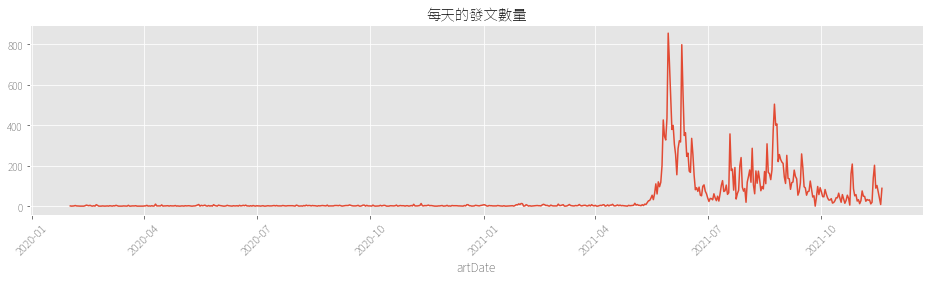

In [39]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(16,3.5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

### 2020年的發文數

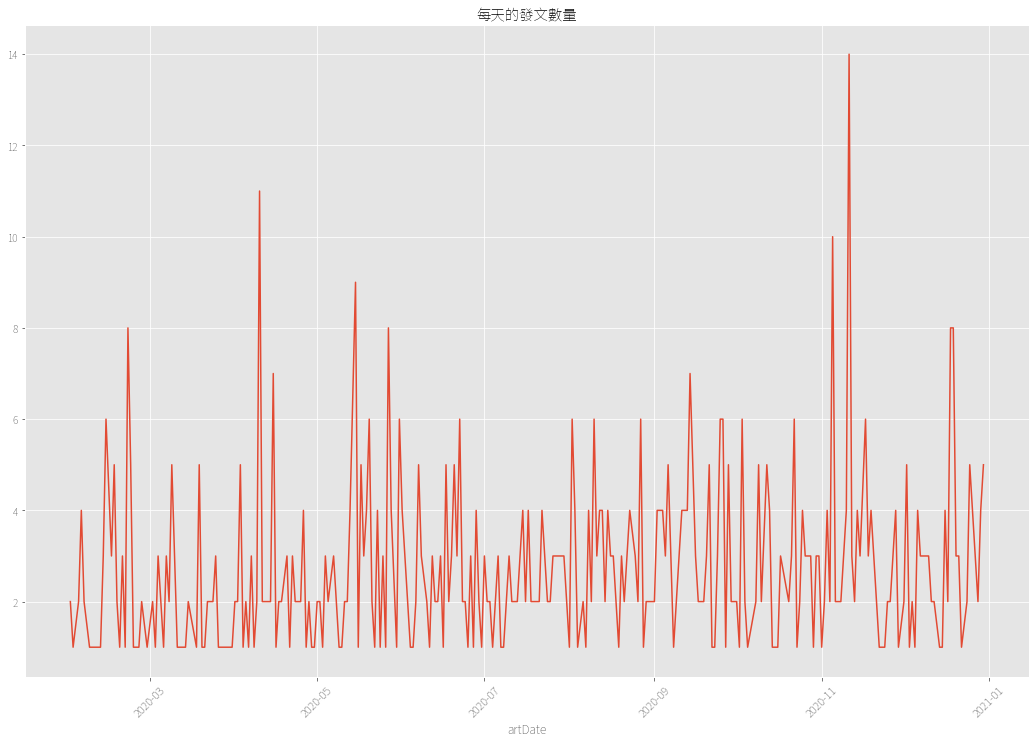

In [40]:
MetaData_2020=MetaData[(MetaData['artDate'] >= '2020-02-01') & (MetaData['artDate'] <= '2020-12-31')]
data_datecount = pd.DataFrame(MetaData_2020.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(18,12))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

發現在2020年發文超過10篇的天數很少。

### 2021年5月~11月的發文數

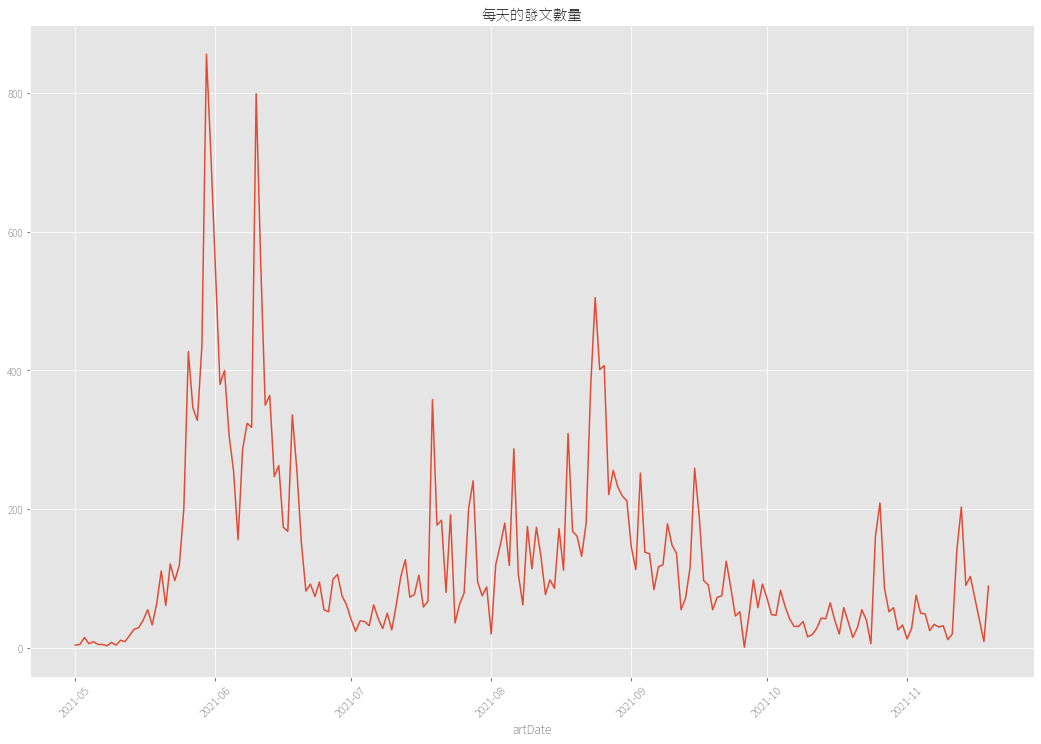

In [41]:
MetaData_2021=MetaData[(MetaData['artDate'] >= '2021-05-01') & (MetaData['artDate'] <= '2021-11-19')]

data_datecount = pd.DataFrame(MetaData_2021.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(18,12))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

- 2021年5月中旬開始發文數增加,大約是2021年5月月底發文數最高,超過800則。事件:5/30高端疫苗宣布，與衛福部疾管署完成「110年國內COVID-19高端新冠肺炎疫苗採購（案號CL110017）合約簽署，合計採購500萬劑疫苗

- 2021年6月10日左右開始下降,事件:6/10 高端疫苗公布實驗結果，完成第二期臨床試驗期間分析解盲。

- 2021年8月下旬又開始上升,事件:8/16 開放本地自行生產的首款新冠疫苗「高端」（Medigen）的接種線上預約。

- 2021年11月討論又上升,事件:11/12 四劑帝國(打高端想出國｢要混打2劑國際疫苗｣！　PTT全驚喊：四劑帝國)

In [42]:
# 發文數最多的前十天
data_datecount.sort_values(by=['count'],ascending=False).head(10)

count
artDate          
2021-05-30    856
2021-06-10    799
2021-05-31    709
2021-06-11    557
2021-06-01    546
2021-08-24    505
2021-05-29    436
2021-05-26    427
2021-08-26    407
2021-08-25    401

### 3.3 正負向情緒分數聲量折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [44]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size().reset_index(name='size')
sentiment_count.head()

artDate sentiments  size
0 2020-02-01   negative    20
1 2020-02-01   positive     8
2 2020-02-02   negative     1
3 2020-02-04   negative    56
4 2020-02-04   positive    24

### 整體的正負向情緒分數聲量折線圖(2020/2/1~2021/11/19)

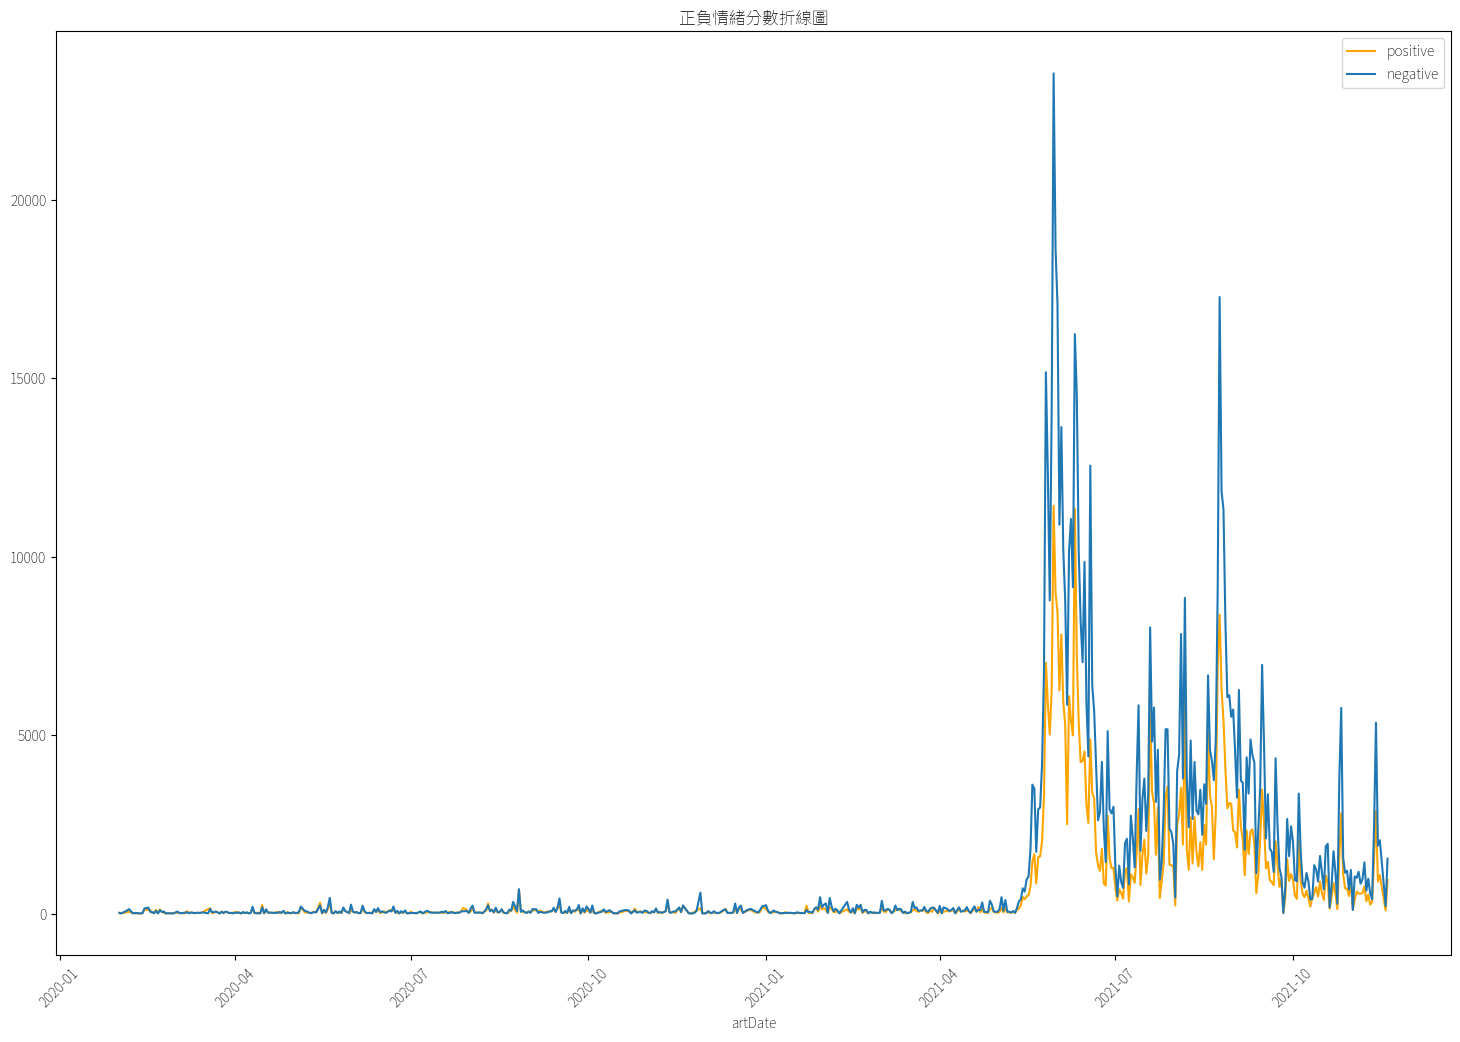

In [47]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(18,12))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artDate')
plt.show()

畫出每天的情緒總分數，可以看到大概在2021年5月開始正負面情緒都逐漸攀升。

### 2021年5月之後的正負向情緒分數聲量折線圖

In [51]:
# 篩選出2021年5月之後資料
data_2021_after5=data[(data['artDate'] >= '2021-05-01') & (data['artDate'] <= '2021-11-19')]

#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_2021_after5, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size().reset_index(name='size')
sentiment_count.head()

artDate sentiments  size
0 2021-05-01   negative    48
1 2021-05-01   positive    19
2 2021-05-02   negative   129
3 2021-05-02   positive    44
4 2021-05-03   negative   457

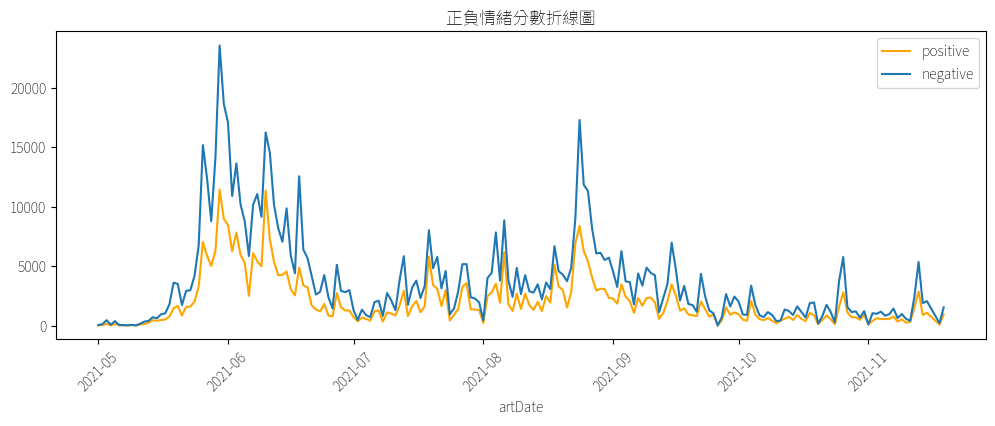

In [56]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(12,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例

plt.xlabel('artDate')
plt.show()

### 3.4 正負向情緒分數比例折線圖

### 整體的正負向情緒分數比例折線圖(2020/2/1~2021/11/19)

In [57]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size().reset_index(name='size')

In [58]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

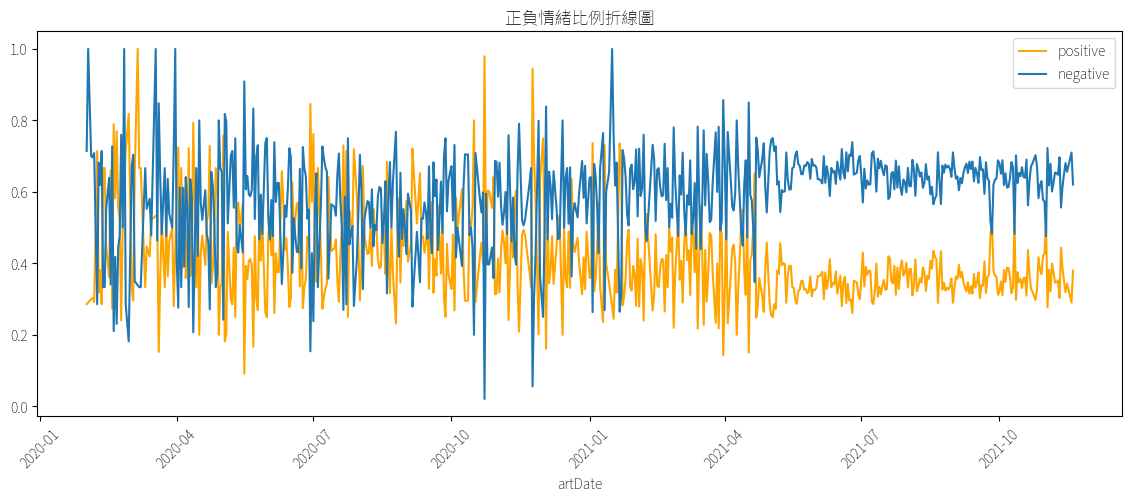

In [59]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] >= '2020/02/01'] #大於起日
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(14,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
# plt.axvline(x=datetime.strptime('2021-03-18', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-19', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-25', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-26', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

- 透過上圖我們可以發現在2020年2月到12月聲量有正有負。
- 而在2021年開始則是負面聲量居多，大概5月份後都是充滿負面聲量。

### 2020年的正負向情緒分數比例折線圖

In [63]:
# 篩選出2020年資料
data_2020=data[(data['artDate'] >= '2020-02-01') & (data['artDate'] <= '2020-12-31')]

#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_2020, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size().reset_index(name='size')
sentiment_count.head()

artDate sentiments  size
0 2020-02-01   negative    20
1 2020-02-01   positive     8
2 2020-02-02   negative     1
3 2020-02-04   negative    56
4 2020-02-04   positive    24

In [64]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

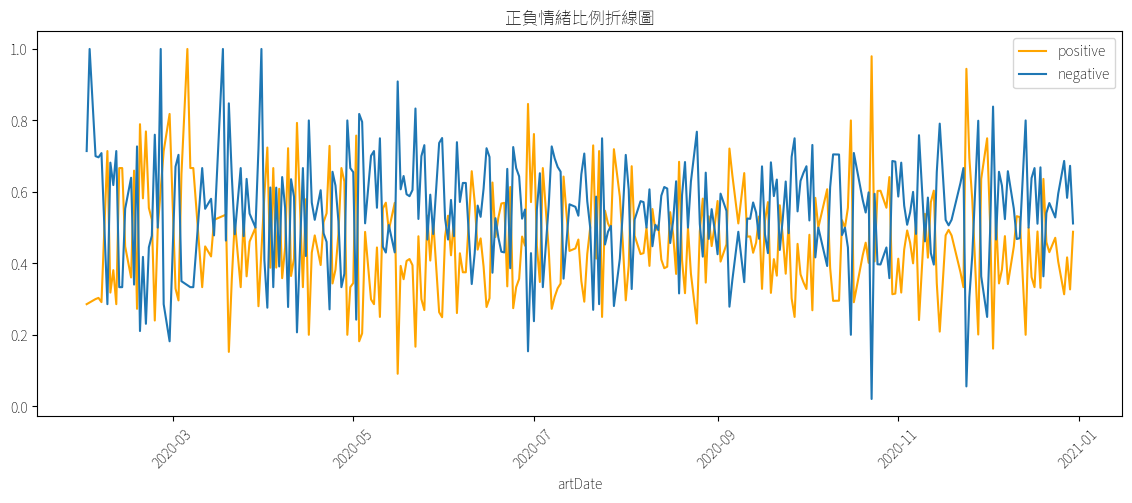

In [65]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] <= '2020-12-31']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(14,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
# plt.axvline(x=datetime.strptime('2021-03-18', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

### 2021年的正負向情緒分數比例折線圖

In [66]:
# 篩選出2021年資料
data_2021=data[(data['artDate'] >= '2021-01-01') & (data['artDate'] <= '2021-12-31')]

#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_2021, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size().reset_index(name='size')
sentiment_count.head()

artDate sentiments  size
0 2021-01-01   negative   233
1 2021-01-01   positive   131
2 2021-01-02   negative    84
3 2021-01-02   positive    47
4 2021-01-03   negative    10

In [67]:
sentiment_count.sort_values(by=['size','sentiments'],ascending=False).loc[sentiment_count['size'] == sentiment_count['size'].max()]
#找到整體負面情緒最高是5/30 共23536個
# sentiment_count.head(60) #找到2021年1月負面情緒最高是1/29  共458個

artDate sentiments   size
275 2021-05-30   negative  23536

In [68]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

In [69]:
# sentiment_count_r.head()
# sentiment_count_r.sort_values(by=['ratio'],ascending=False).loc[sentiment_count_r['ratio'] == sentiment_count_r['ratio'].max()]
sentiment_count_r.sort_values(by=['ratio'],ascending=False).head(20)

artDate sentiments  size     ratio
24  2021-01-16   negative     3  1.000000
161 2021-03-31   negative    18  0.857143
193 2021-04-17   negative    17  0.850000
177 2021-04-09   negative     8  0.800000
127 2021-03-14   negative    54  0.782609
155 2021-03-28   negative   165  0.781991
97  2021-02-26   negative    32  0.780488
135 2021-03-18   negative   322  0.772182
167 2021-04-03   negative   172  0.767857
151 2021-03-26   negative    46  0.766667
16  2021-01-10   negative    13  0.764706
63  2021-02-06   negative   133  0.760000
25  2021-01-17   negative    34  0.755556
203 2021-04-22   negative    97  0.751938
221 2021-05-03   negative   457  0.750411
219 2021-05-02   negative   129  0.745665
327 2021-06-25   negative  2378  0.739198
5   2021-01-03   positive    28  0.736842
211 2021-04-27   negative   357  0.736082
32  2021-01-21   positive    25  0.735294

- 負面情緒比例高:2021/1/16負面情緒占比100%,有3個。2021/3/31 負面情緒占比86%,有18個。
2021/4/17 負面情緒占比85%,有17個。

- 正面情緒比例高:2021/1/3 正面情緒占比74%,有28個。
2021/1/21 正面情緒占比74%,有25個。

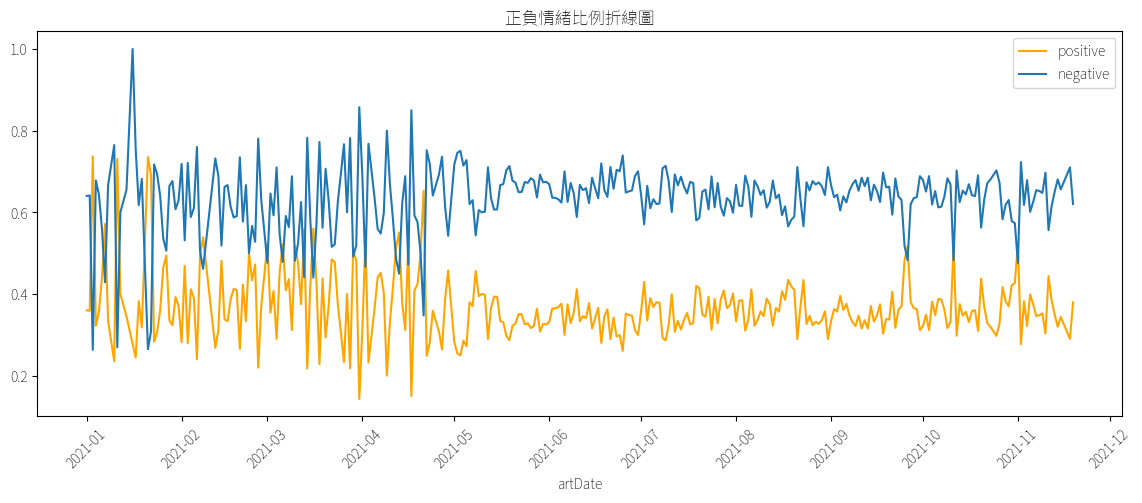

In [70]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] >= '2021-01-01'] #大於起日
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(14,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
# plt.axvline(x=datetime.strptime('2021-01-16', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

- 2021年大致都是負面情緒佔比大。不到5天是正面情緒比例高於負面情緒(e.g.2021/4/21)

In [55]:
# 以正面情緒比例排序
a=sentiment_count_r[(sentiment_count_r['sentiments']=='positive')]
a.sort_values(by=['ratio'],ascending=False).head(10)

artDate sentiments  size     ratio
5   2021-01-03   positive    28  0.736842
32  2021-01-21   positive    25  0.735294
19  2021-01-11   positive    38  0.730769
34  2021-01-22   positive   220  0.691824
202 2021-04-21   positive   186  0.652632
13  2021-01-07   positive    48  0.571429
132 2021-03-16   positive    28  0.560000
126 2021-03-13   positive    19  0.558824
186 2021-04-13   positive    82  0.550336
68  2021-02-08   positive     7  0.538462

### 3.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [71]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict   

- 2021年5月中旬開始發文數增加,大約是2021年5月月底發文數最高,超過800則。

- 2021年6月10日左右開始下降,事件:6/10 高端疫苗公布實驗結果，完成第二期臨床試驗期間分析解盲。

- 2021年8月下旬又開始上升,事件:8/16 開放本地自行生產的首款新冠疫苗「高端」（Medigen）的接種線上預約。

- 2021年11月討論又上升,事件:11/12 四劑帝國(打高端想出國｢要混打2劑國際疫苗｣！　PTT全驚喊：四劑帝國)

### 2021-05-30 文字雲
- 以發文數較高的幾天，且在新聞上有重大事件，觀察在PTT討論的狀況

- 2021/5/30事件:高端疫苗宣布，與衛福部疾管署完成「110年國內COVID-19高端新冠肺炎疫苗採購（案號CL110017）合約簽署，合計採購500萬劑疫苗

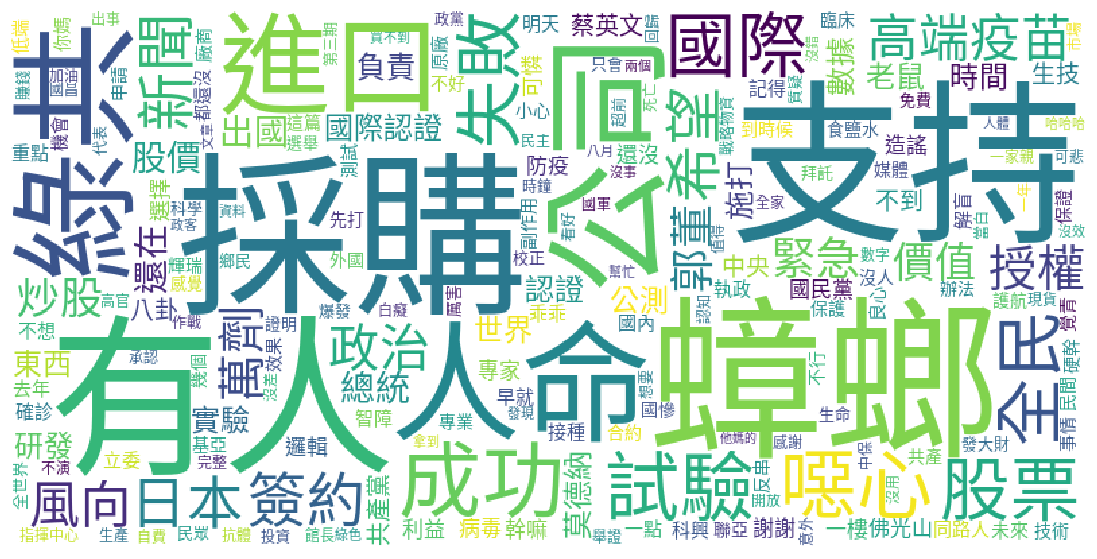

In [72]:
dict_210530 = Wc_dict(word_count,"2021-05-30",450,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_210530)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-06-10 文字雲
- 2021/6/10事件:高端疫苗公布實驗結果，完成第二期臨床試驗期間分析解盲。

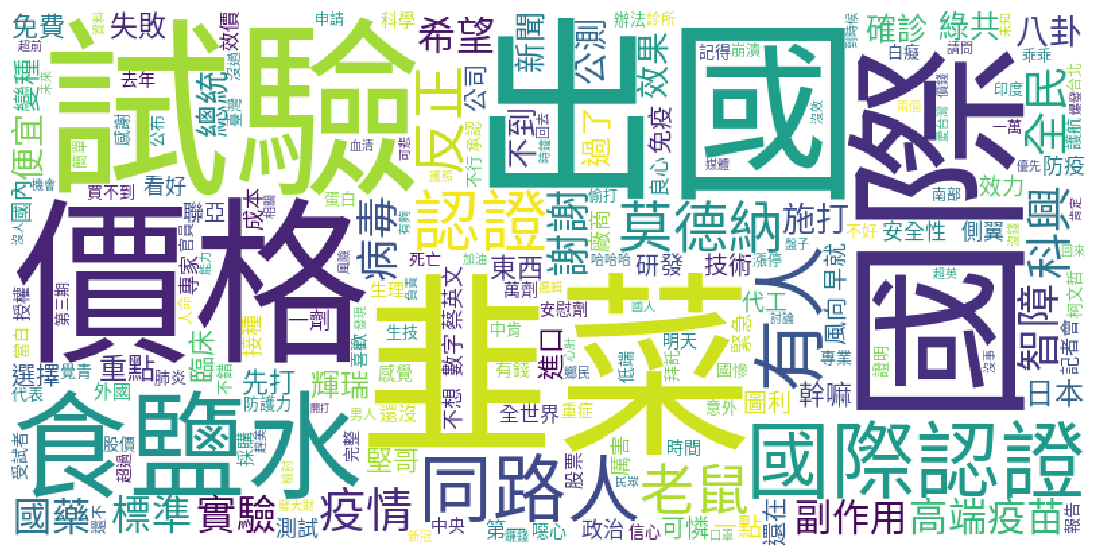

In [73]:
dict_210610 = Wc_dict(word_count,"2021-06-10",450,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_210610)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

- 出現字詞"韭菜"，表示討論板也有關注高端股價
- 事件:2021/6/9解盲前夕 高端股價漲停
-      2021/6/10 工商時報:高端風暴！主力出招養套殺 他積蓄賠光光 (男大生期待能一夜致富,卻在跌停時賠光積蓄)

### 2021-08-16 文字雲
- 2021/8/16事件:開放本地自行生產的首款新冠疫苗「高端」（Medigen）的接種線上預約。

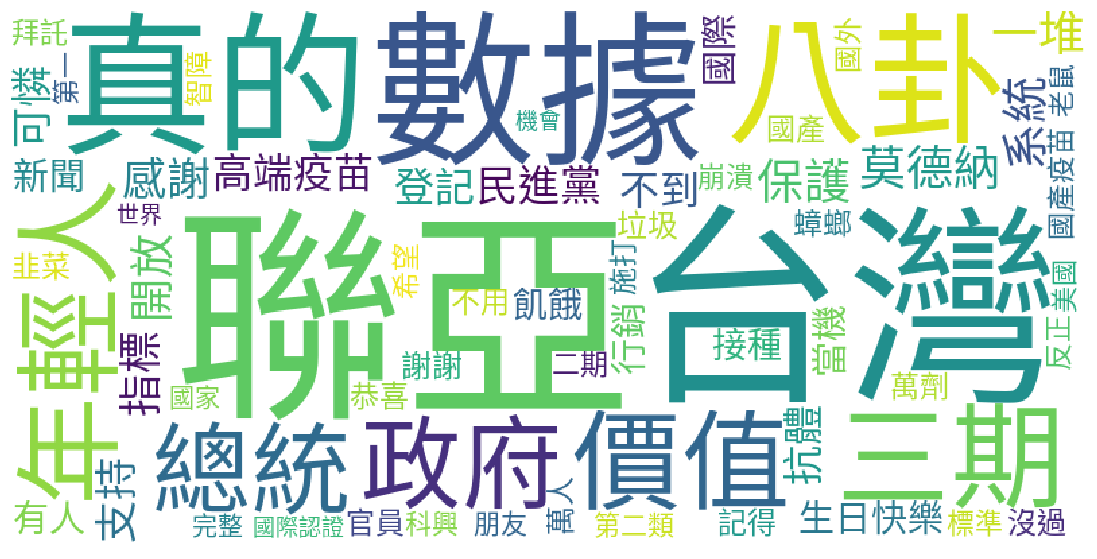

In [74]:
dict_210816 = Wc_dict(word_count,"2021-08-16",450,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_210816)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-11-12 文字雲
- 2021/11/12事件:打高端想出國｢要混打2劑國際疫苗｣！　PTT全驚喊：四劑帝國

- 從文字雲看到，呼應高端疫苗在國際認證上的風波，未來可不可以出國的議題

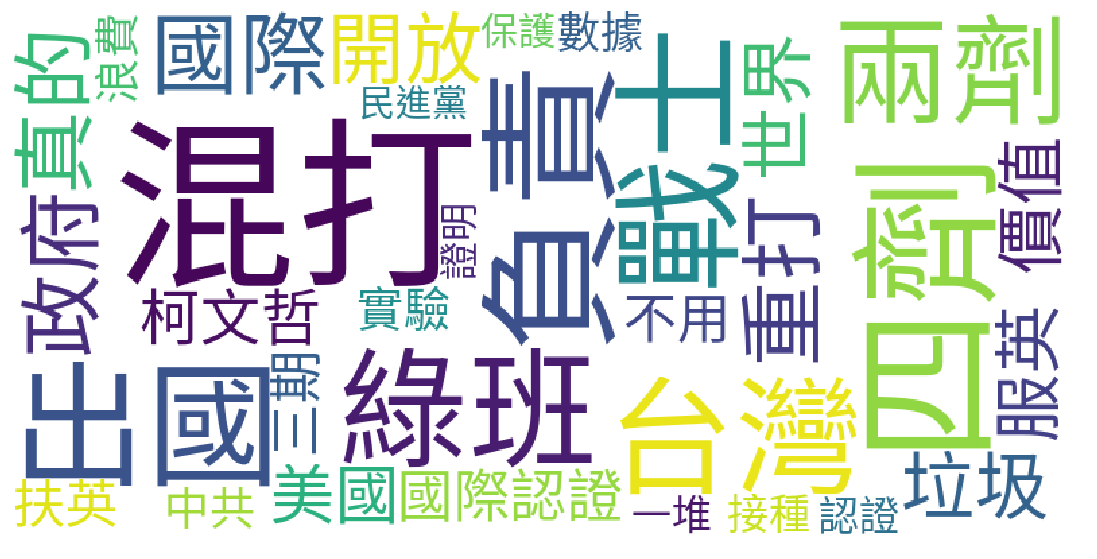

In [75]:
dict_211112 = Wc_dict(word_count,"2021-11-12",450,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_211112)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-11-19 文字雲
在2021/11/10之後討論度開始下降  
- 觀察討論本次探討的最後一天2021/11/19的文字雲

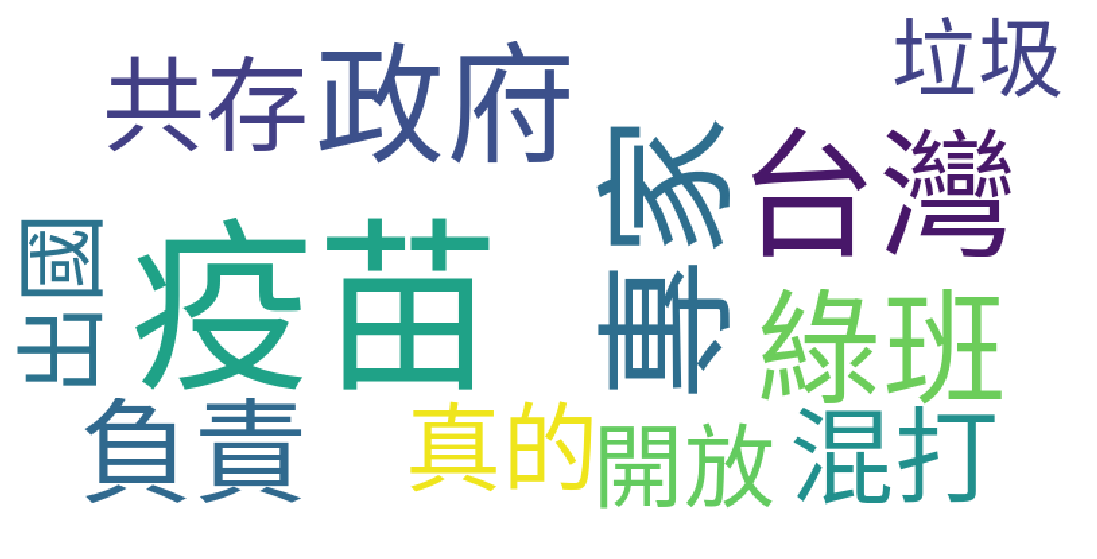

In [76]:
dict_211119 = Wc_dict(word_count,"2021-11-19",450,50)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_211119)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [77]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

word sentiments   size
456   垃圾   negative  58324
361   可憐   negative  24960
33    不到   negative  21386
168   保護   positive  18437
640   希望   positive  18292

### 整體的情緒代表字(2020/2/1~2021/11/19)

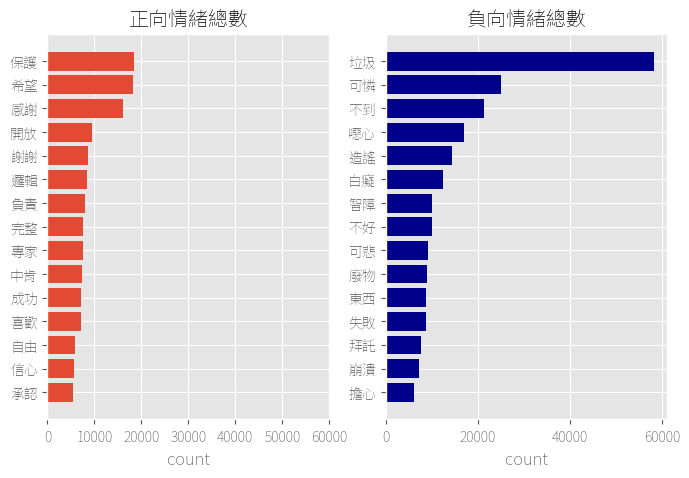

In [78]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.xlim(0,60000)
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

另外，也可以依據不同日期觀察情緒代表字的變化
### 2021-05-30 正負情緒代表字 (高端宣布500萬劑疫苗合約)

In [79]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_210530= sentiment_date_sum[sentiment_date_sum['artDate']=="2021-05-30"].sort_values(by=['size'], ascending=False)
sentiment_210530.head()

artDate word sentiments  size
6712 2021-05-30   垃圾   negative  2158
6700 2021-05-30   噁心   negative   830
6742 2021-05-30   失敗   negative   752
6800 2021-05-30   希望   positive   704
6506 2021-05-30   不到   negative   510

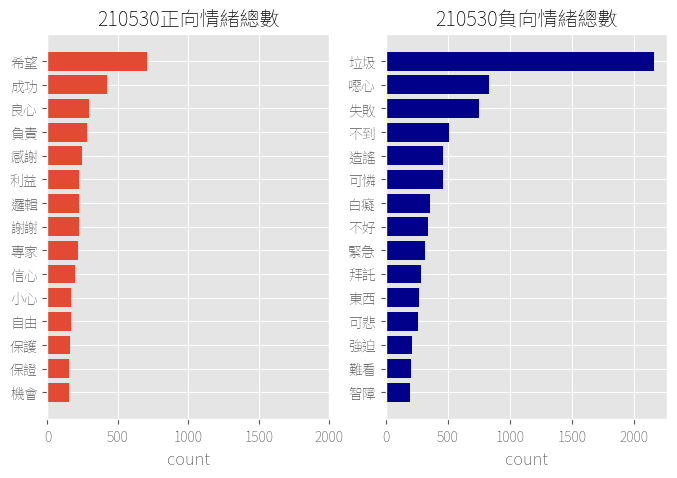

In [81]:
p_sum = sentiment_210530[sentiment_210530["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_210530[sentiment_210530["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('210530正向情緒總數')
plt.xlabel('count')
plt.xlim(0,2000)
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('210530負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.show()

### 2021-06-10正負情緒代表字 (完成第二期臨床試驗期間分析解盲)

In [82]:
#篩選日期
sentiment_210610 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-06-10"].sort_values(by=['size'], ascending=False)
sentiment_210610.head()

artDate word sentiments  size
13669 2021-06-10   垃圾   negative  1204
13559 2021-06-10   保護   positive   839
13750 2021-06-10   希望   positive   552
13502 2021-06-10   不到   negative   502
13693 2021-06-10   失敗   negative   486

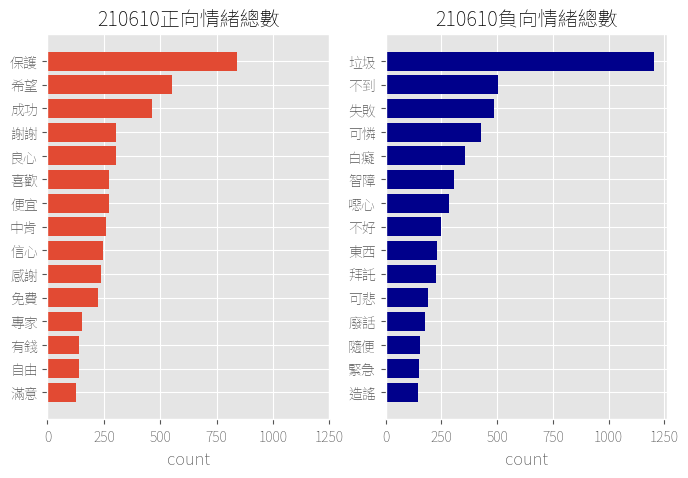

In [83]:
p_sum = sentiment_210610[sentiment_210610["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_210610[sentiment_210610["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('210610正向情緒總數')
plt.xlabel('count')
plt.xlim(0,1250)
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('210610負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.show()

### 2021-08-16正負情緒代表字 (開放「高端」（Medigen）的接種線上預約)

In [85]:
#篩選日期
sentiment_210816 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-08-16"].sort_values(by=['size'], ascending=False)
sentiment_210816.head()

artDate word sentiments  size
31415 2021-08-16   感謝   positive   228
31354 2021-08-16   可憐   negative   204
31314 2021-08-16   不到   negative   196
31366 2021-08-16   垃圾   negative   166
31546 2021-08-16   飢餓   negative   166

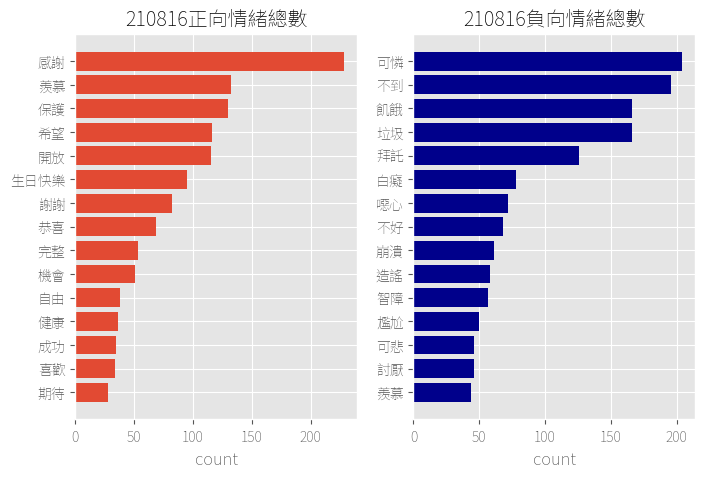

In [86]:
p_sum = sentiment_210816[sentiment_210816["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_210816[sentiment_210816["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
#plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('210816正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('210816負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.show()

### 2021-11-12正負情緒代表字 (打高端想出國｢要混打2劑國際疫苗｣)

In [87]:
#篩選日期
sentiment_211112 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-11-12"].sort_values(by=['size'], ascending=False)
sentiment_211112.head()

artDate word sentiments  size
47950 2021-11-12   負責   positive   260
47848 2021-11-12   垃圾   negative   222
47959 2021-11-12   重打   negative   155
47962 2021-11-12   開放   positive   124
47912 2021-11-12   浪費   negative   120

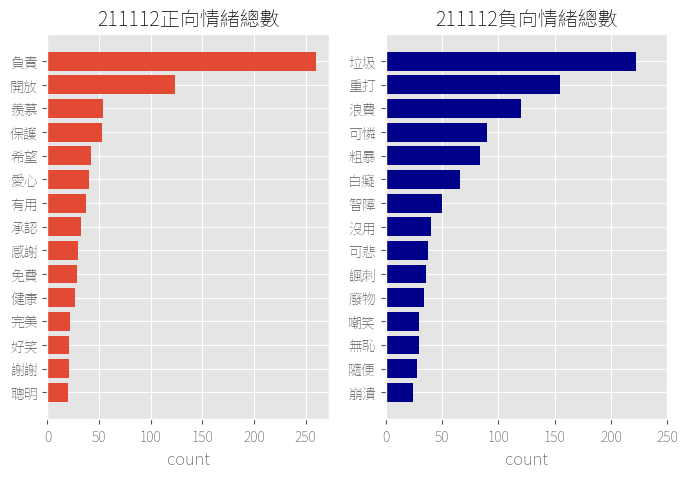

In [89]:
p_sum = sentiment_211112[sentiment_211112["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_211112[sentiment_211112["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
#plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('211112正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('211112負向情緒總數')
plt.xlabel('count')
plt.xlim(0,250)
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.show()

- 比較正負情緒代表字，可以發現在負面情緒的部分都有看到「可憐」、「垃圾」、「白癡」等不好聽字眼。  
- 在正面情緒可以看到比較多「希望」、「保護」等。
- 而在2021/11/12則是新增了「重打」、「浪費」的字詞。

### 3.7 歸類正負面文章
- 接者將正負面情緒的文章分開探討，看看有什麼發現。  
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，大概分類文章屬於正面還是負面。

In [74]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments                                             artUrl  negative  \
0           https://www.ptt.cc/bbs/Gossiping/M.1580620433....        11   
1           https://www.ptt.cc/bbs/Gossiping/M.1580629746....         9   
2           https://www.ptt.cc/bbs/Gossiping/M.1580712980....         1   
3           https://www.ptt.cc/bbs/Gossiping/M.1580822285....        11   
4           https://www.ptt.cc/bbs/Gossiping/M.1580855875....        45   

sentiments  positive  
0                  2  
1                  6  
2                  0  
3                 14  
4                 10

In [75]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

type   size
0  negative  20511
1  positive   6773

## 正負情緒文章數量統計圖

In [76]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
#article_type_date

### 2020年2月~4月 正負情緒文章數量統計圖

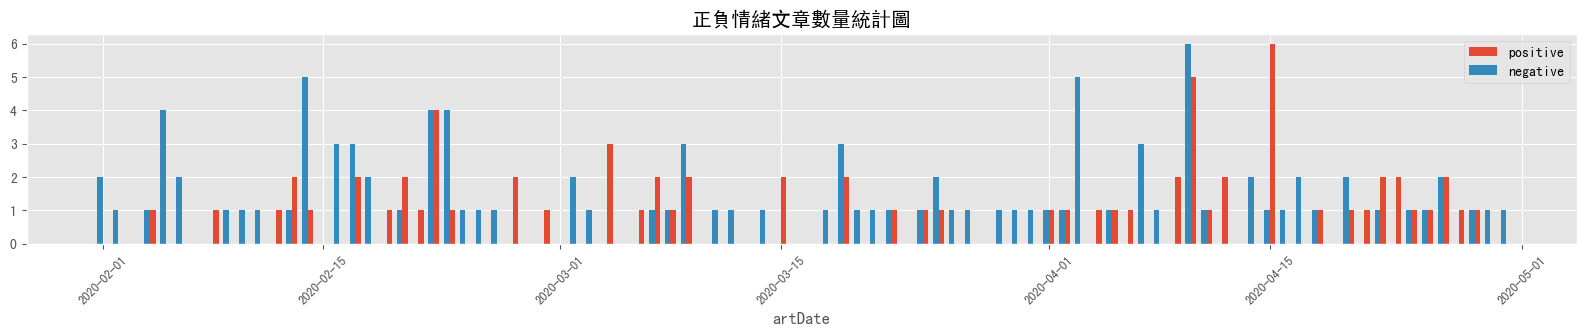

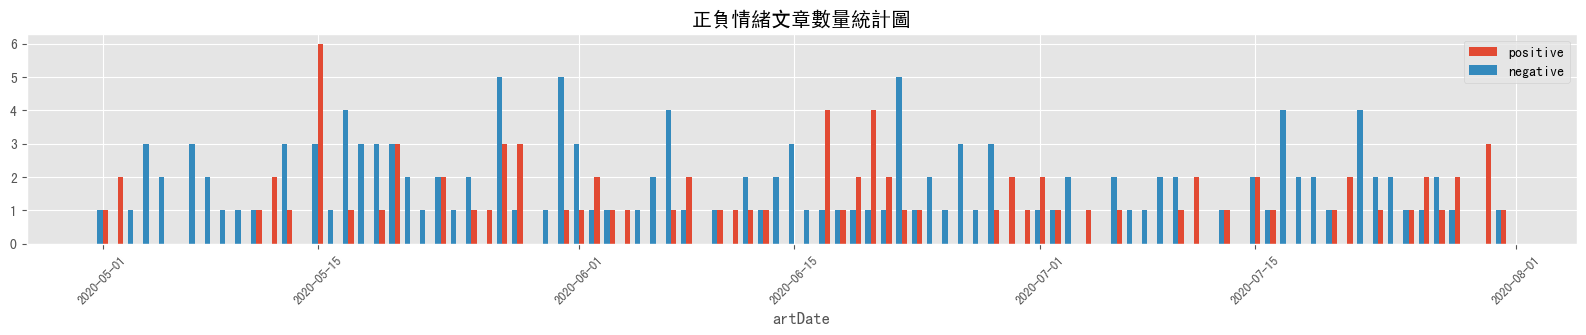

In [77]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2020/02/01")&(article_type_date["artDate"]<"2020/05/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2020/02/01")&(article_type_date["artDate"]<"2020/05/01")]

plt.figure(figsize=(20,6))     # 顯示圖框架大小 (寬,高)
plt.subplot(2, 1, 1)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2020/05/01")&(article_type_date["artDate"]<"2020/08/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2020/05/01")&(article_type_date["artDate"]<"2020/08/01")]

plt.figure(figsize=(20,6))     # 顯示圖框架大小 (寬,高)
plt.subplot(2, 1, 2)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

### 同期比較:2020和2021年在5月~7月的正負情緒文章數量統計圖

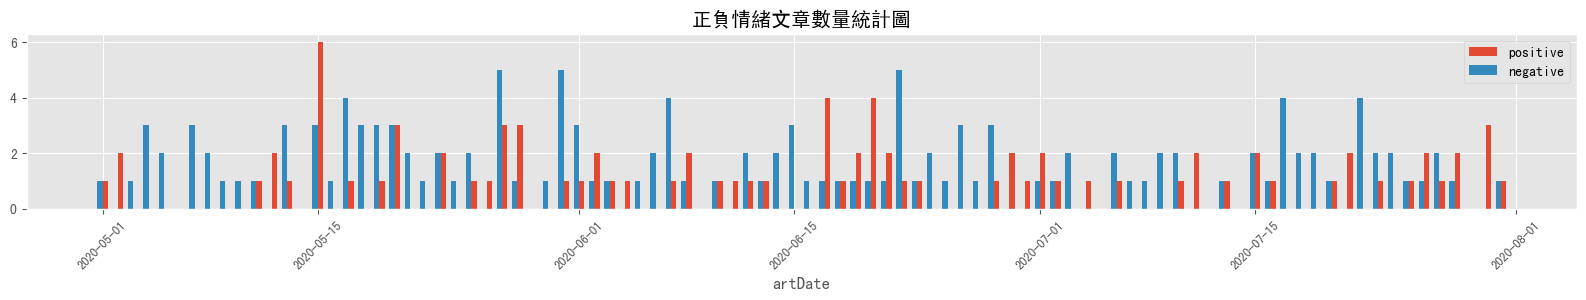

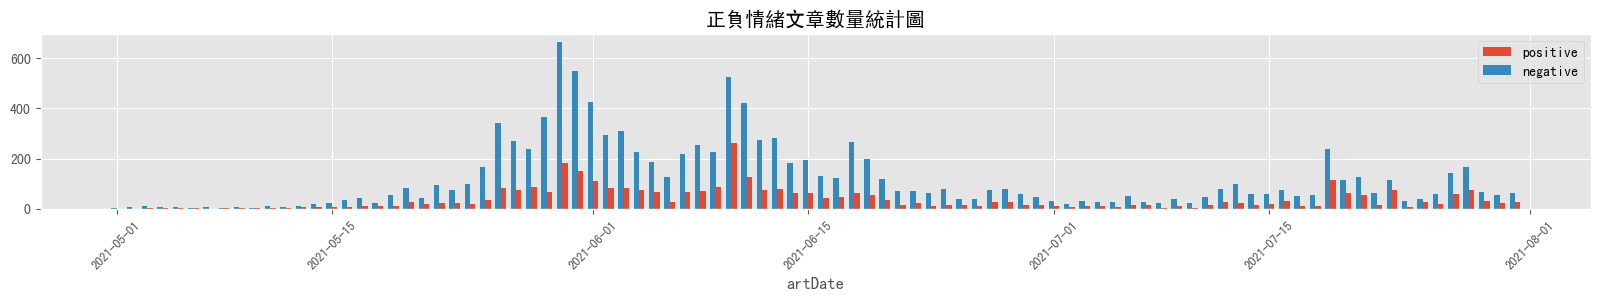

In [78]:
# 2020年5月~7月
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2020/05/01")&(article_type_date["artDate"]<"2020/08/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2020/05/01")&(article_type_date["artDate"]<"2020/08/01")]

plt.figure(figsize=(20,5))     # 顯示圖框架大小 (寬,高)
plt.subplot(2, 1, 1)
# plt.figure(figsize=(20,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

# 2021年5月~7月
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/05/01")&(article_type_date["artDate"]<"2021/08/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/05/01")&(article_type_date["artDate"]<"2021/08/01")]

plt.figure(figsize=(20,5))     # 顯示圖框架大小 (寬,高)
plt.subplot(2, 1, 2)
# plt.figure(figsize=(15,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()


### 同期比較:2020和2021年在8月~11月的正負情緒文章數量統計圖

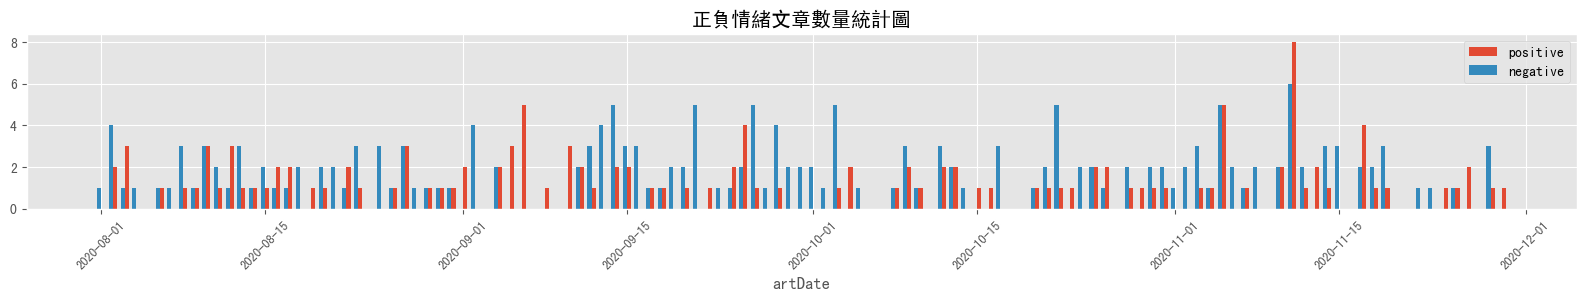

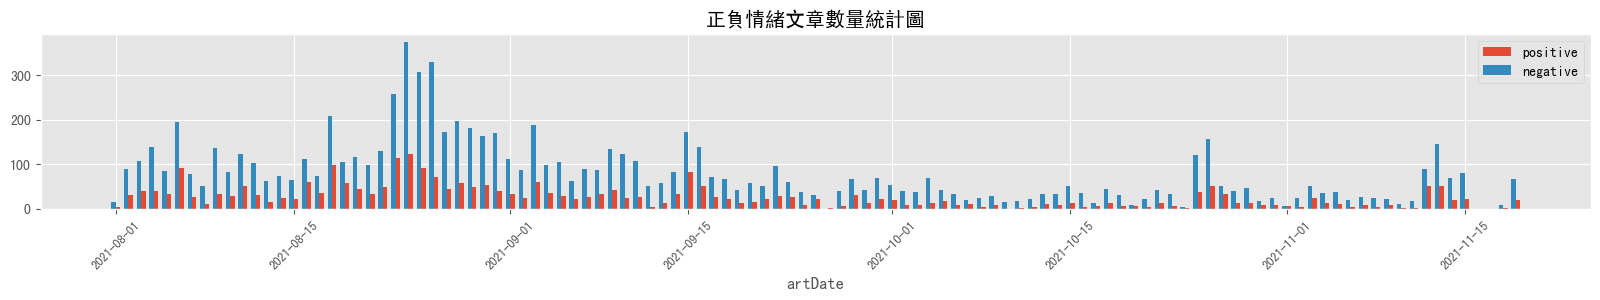

In [79]:
# 2020年8月~11月
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2020/08/01")&(article_type_date["artDate"]<"2020/12/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2020/08/01")&(article_type_date["artDate"]<"2020/12/01")]

plt.figure(figsize=(20,5))     # 顯示圖框架大小 (寬,高)
plt.subplot(2, 1, 1)
# plt.figure(figsize=(20,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
# plt.ylim(0,400)
plt.show()

# 2021年8月~11月
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/08/01")&(article_type_date["artDate"]<"2021/12/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/08/01")&(article_type_date["artDate"]<"2021/12/01")]

plt.figure(figsize=(20,5))     # 顯示圖框架大小 (寬,高)
plt.subplot(2, 1, 2)
# plt.figure(figsize=(15,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
# plt.ylim(0,400)
plt.show()

### 2021年5月~7月 正負情緒文章數量統計圖

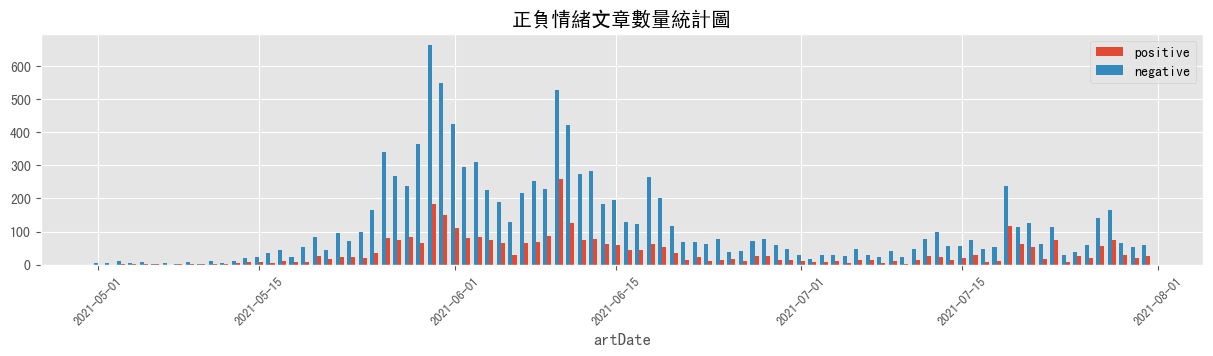

In [80]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/05/01")&(article_type_date["artDate"]<"2021/08/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/05/01")&(article_type_date["artDate"]<"2021/08/01")]

plt.figure(figsize=(15,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()


### 2021年8月~11月 正負情緒文章數量統計圖

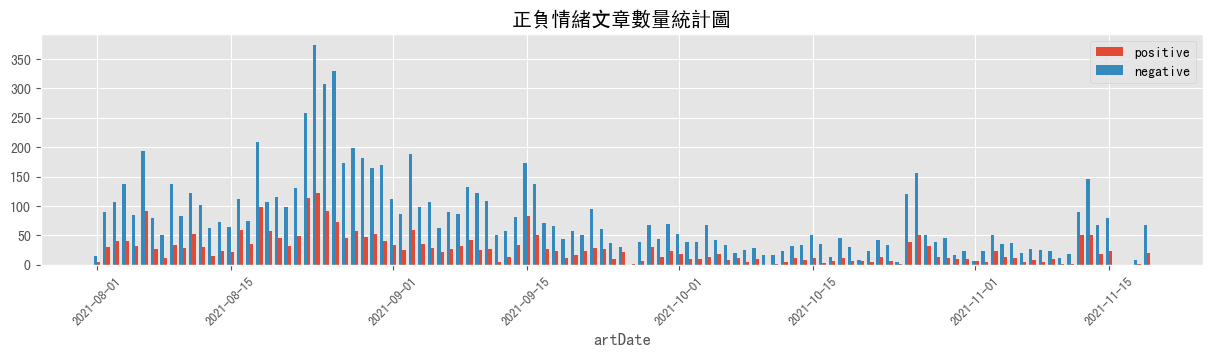

In [81]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/08/01")&(article_type_date["artDate"]<="2021/12/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/08/01")&(article_type_date["artDate"]<="2021/12/01")]

plt.figure(figsize=(15,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

### 3.8 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [82]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

### 情緒關鍵字:負面情緒文章

In [83]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

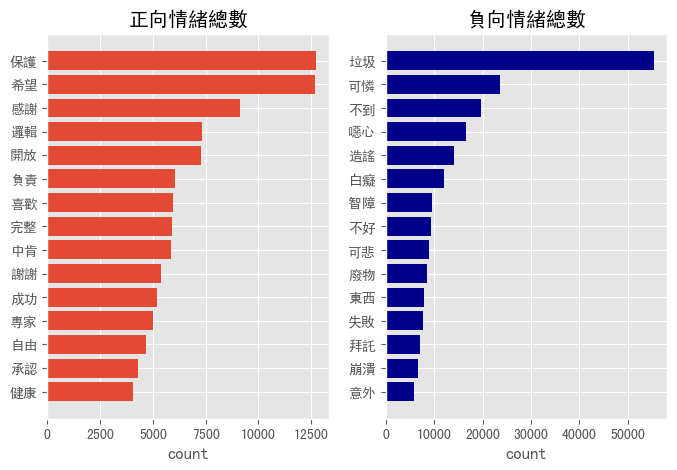

In [84]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.xlim(0,50000)
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 情緒關鍵字:正面情緒文章

In [85]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

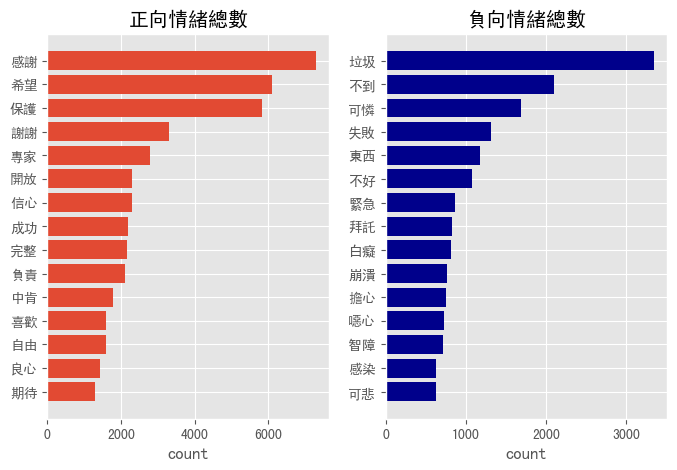

In [86]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.xlim(0,6000)
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

- 從正負面情緒圖觀察發現，正面和負面的關鍵字沒有顯著的差異；
- 負面情緒較高的文章比較常出現「垃圾」、「可憐」、「失敗」等討論高端疫苗負面影響的字詞；
- 正面情緒較高的文章出現較多的「感謝」、「希望」、「保護」等字詞，對於高端疫苗以期望施打後提升身體保護力為主。

## 4.SnowNLP 情緒分析

### 4.1 平均情緒分數時間序列圖

In [ ]:
data_orig['sentimentValue'] = data_orig.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)

In [272]:
data_sentimentValue = data_orig[['artDate','sentimentValue']].groupby('artDate').mean().reset_index()
data_sentimentValue.head(5)

artDate  sentimentValue
0 2020-02-01        0.445492
1 2020-02-02        0.634489
2 2020-02-04        0.427952
3 2020-02-05        0.441500
4 2020-02-06        0.368315

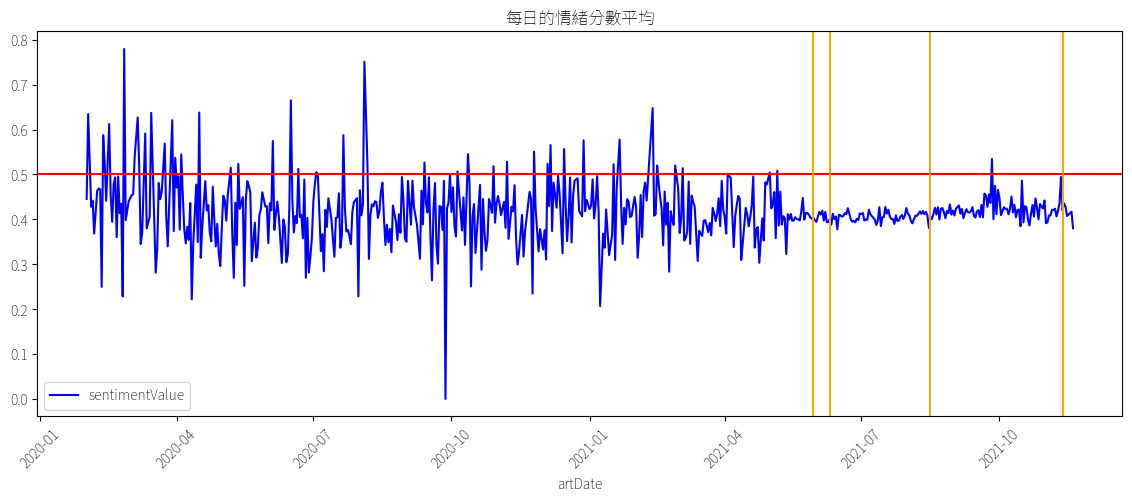

In [278]:
plt.figure(figsize=(14,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使中文能正常顯示
plt.title('每日的情緒分數平均')
plt.plot(data_sentimentValue['artDate'].tolist(), data_sentimentValue['sentimentValue'], label='sentimentValue',color="blue")
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
plt.axhline(y=0.5, color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-05-30', "%Y-%m-%d"), color="orange", ls="-")
plt.axvline(x=datetime.strptime('2021-06-10', "%Y-%m-%d"), color="orange", ls="-")
plt.axvline(x=datetime.strptime('2021-08-16', "%Y-%m-%d"), color="orange", ls="-")
plt.axvline(x=datetime.strptime('2021-11-12', "%Y-%m-%d"), color="orange", ls="-")
plt.xlabel('artDate')
plt.show()

### 4.2 特定事件日的正負向情緒聲量與用字

### 2021-05-30  (高端宣布500萬劑疫苗合約)

In [116]:
def get_sentiment(sent):
    try:
        s = SnowNLP(sent)
        s = s.sentiments
    except:
        s = 0.5
    return s

In [117]:
# 幫每句話加上情緒分數
data_0530= data_orig[data_orig['artDate'] == '2021-05-30']
data_0530['sentimentValue'] = data_0530.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
data_0530.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


artDate                                             artUrl  \
3847 2021-05-30  https://www.ptt.cc/bbs/Gossiping/M.1622333388....   
3848 2021-05-30  https://www.ptt.cc/bbs/Gossiping/M.1622333555....   
3849 2021-05-30  https://www.ptt.cc/bbs/Gossiping/M.1622334138....   
3850 2021-05-30  https://www.ptt.cc/bbs/Gossiping/M.1622334273....   
3851 2021-05-30  https://www.ptt.cc/bbs/Gossiping/M.1622334444....   

                                               sentence  sentimentValue  
3847  要跟原廠買才有保障所以先不買簡單說就是不想背鍋那好國產疫苗三期都沒有那幹嘛要買有國際認證的疫...        0.000005  
3848  共同敵人是民進黨吧現在就是民進黨在那邊各種阻撓啊地方首長無論國民黨和民眾黨都提出了不錯的方案...        0.000000  
3849  欸欸我今天看台派分享看到的影片才知道原來那個疫苗保護力的數會被流行環境影響喔人家影片說比較高...        0.039194  
3850  高端一劑疫苗能賺多少如果高端賣出四千萬劑疫苗能賺多少錢國產疫苗我們有股份嗎賺到的錢利益是全民...        0.000477  
3851  一個都還沒三期的公司讓政府能整天說有國產而且還押上日期我真心覺得不可思議然後會有人說有美國技...        0.000034

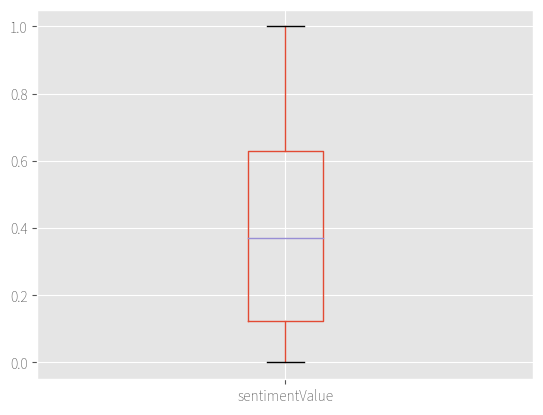

In [120]:
data_0530.boxplot(column=['sentimentValue'], showfliers=True)

### 正面句子或文章的用詞

In [187]:
pos_0530 =data_0530.loc[data_0530['sentimentValue'] >= 0.7]
pos_0530 = pd.merge(pos_0530,data[data['artDate']=='20210530'][['artUrl','word']],on='artUrl',how='left')
pos_0530 = pos_0530[['artDate','sentimentValue','word']]
pos_0530_count = pos_0530.groupby('word').size().reset_index(name='size')
pos_0530_count = pos_0530_count[[(len(w)>2 and w not in stopWords) for w in pos_0530_count['word']]]

In [208]:
pos_0530_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
pos_0530_count = pos_0530_count[pos_0530_count['size']>5000]  #過濾出現太少次的字
pos_0530_count = pos_0530_count[pos_0530_count['size']<10000]
pos_0530_count.head(5)

word  size
29316   高嘉瑜  9361
3603    全世界  9214
2048   人體實驗  9020
12810  指揮中心  8703
29081   食鹽水  8564

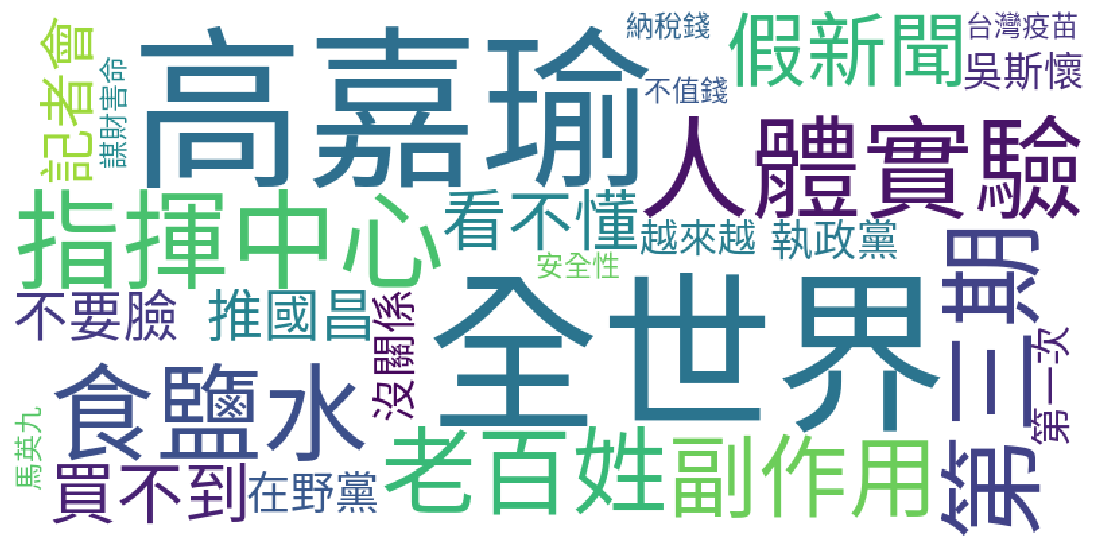

In [209]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(pos_0530_count['word'], pos_0530_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 負面句子或文章的用詞

In [192]:
neg_0530 =data_0530.loc[data_0530['sentimentValue'] <= 0.4]
neg_0530 = pd.merge(neg_0530,data[data['artDate']=='20210530'][['artUrl','word']],on='artUrl',how='left')
neg_0530 = neg_0530[['artDate','sentimentValue','word']]
neg_0530_count = neg_0530.groupby('word').size().reset_index(name='size')
neg_0530_count = neg_0530_count[[(len(w)>2 and w not in stopWords) for w in neg_0530_count['word']]]

In [193]:
neg_0530_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
neg_0530_count = neg_0530_count[neg_0530_count['size']>10000]  #過濾出現太少次的字
neg_0530_count.head(5)

word    size
16774   民進黨  351974
7275   國產疫苗  196446
5894    台灣人  116720
6166    同路人   61709
4008    共產黨   52942

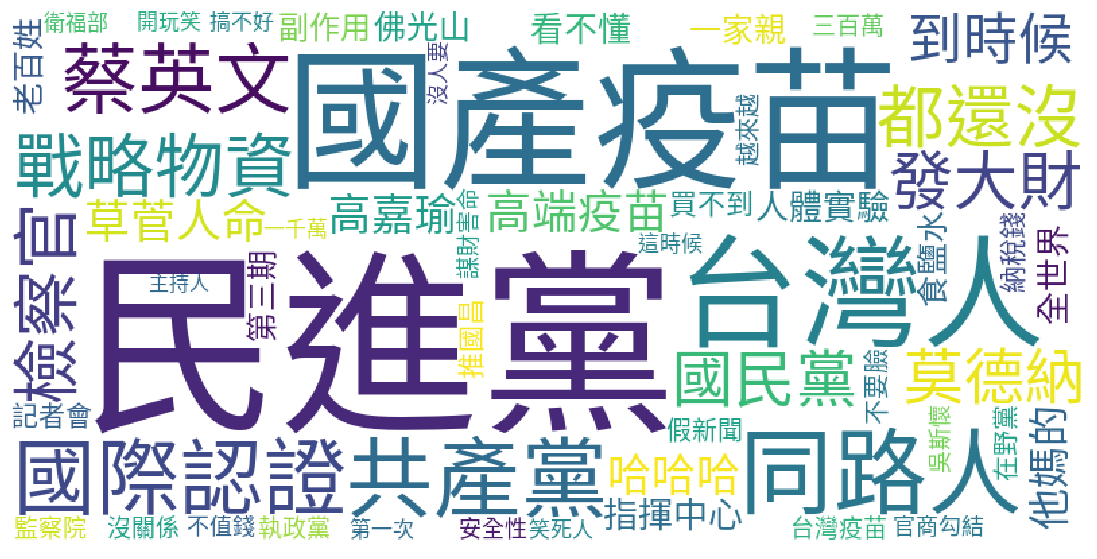

In [194]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(neg_0530_count['word'], neg_0530_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-06-10 (高端疫苗公布實驗結果，完成第二期臨床試驗期間分析解盲)

In [197]:
# 幫每句話加上情緒分數
data_0610= data_orig[data_orig['artDate'] == '2021-06-10']
data_0610['sentimentValue'] = data_0610.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
data_0610.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


artDate                                             artUrl  \
8384 2021-06-10  https://www.ptt.cc/bbs/Gossiping/M.1623283656....   
8385 2021-06-10  https://www.ptt.cc/bbs/Gossiping/M.1623284151....   
8386 2021-06-10  https://www.ptt.cc/bbs/Gossiping/M.1623284434....   
8387 2021-06-10  https://www.ptt.cc/bbs/Gossiping/M.1623284522....   
8388 2021-06-10  https://www.ptt.cc/bbs/Gossiping/M.1623284640....   

                                               sentence  sentimentValue  
8384  欸豆像美國爸爸消息這麼靈通的強國國際上各大疫苗都有美國投資那現在日本美國都知道台灣要自己研發...        0.998476  
8385  今年疫情肆虐每天遲到的記者會破口高端跌停找不到疫苗也沒看到中央有什麼作為只看到叫人民一到五上...        0.000665  
8386  指揮中心強調沒有優先施打一切按照順序那高科技人才又該算第幾類莊人祥目前就是第七類啊台新鮮的肝...        0.998875  
8387  備註請放最後面違者新聞文章刪除媒體來源自由記者署名記者鍾智凱台北報導完整新聞標題等不到疫苗美...        0.001525  
8388             今天解盲了那何時台灣會開始打國產到時候國產一起打一定一堆人不爽打國產怎解有卦        0.495836

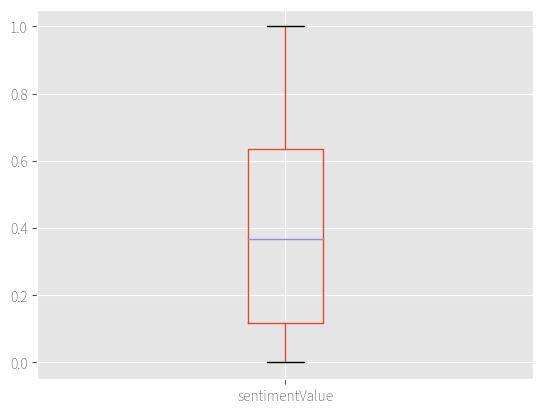

In [198]:
data_0610.boxplot(column=['sentimentValue'], showfliers=True)

### 正面句子或文章的用詞

In [199]:
pos_0610 = data_0610.loc[data_0610['sentimentValue'] >= 0.7]
pos_0610 = pd.merge(pos_0610,data[data['artDate']=='20210610'][['artUrl','word']],on='artUrl',how='left')
pos_0610 = pos_0610[['artDate','sentimentValue','word']]
pos_0610_count = pos_0610.groupby('word').size().reset_index(name='size')
pos_0610_count = pos_0610_count[[(len(w)>2 and w not in stopWords) for w in pos_0610_count['word']]]

In [210]:
pos_0610_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
pos_0610_count = pos_0610_count[pos_0610_count['size']>5000 ]  #過濾出現太少次的字
pos_0610_count = pos_0610_count[pos_0610_count['size']<45000 ]
pos_0610_count.head(5)

word   size
6352   國際認證  28304
25585   食鹽水  24030
20016   莫德納  23168
10136   愛台灣  18939
4083    副作用  18410

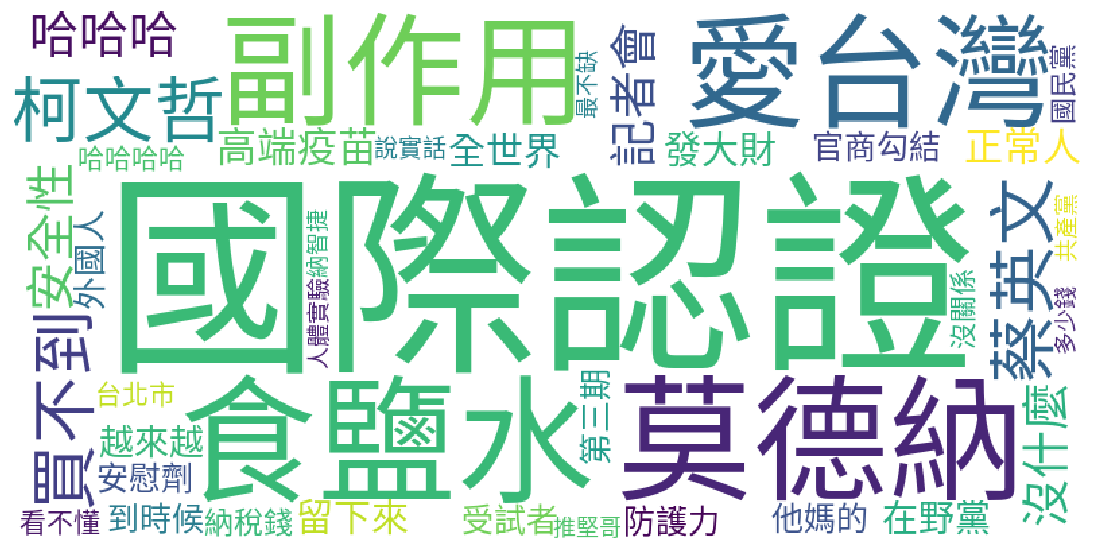

In [211]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(pos_0610_count['word'], pos_0610_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 負面句子或文章的用詞

In [212]:
neg_0610 = data_0610.loc[data_0610['sentimentValue'] <= 0.4]
neg_0610 = pd.merge(neg_0610,data[data['artDate']=='20210610'][['artUrl','word']],on='artUrl',how='left')
neg_0610 = neg_0610[['artDate','sentimentValue','word']]
neg_0610_count = neg_0610.groupby('word').size().reset_index(name='size')
neg_0610_count = neg_0610_count[[(len(w)>2 and w not in stopWords) for w in neg_0610_count['word']]]

In [214]:
neg_0610_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
neg_0610_count = neg_0610_count[neg_0610_count['size']>5000 ]  #過濾出現太少次的字
neg_0610_count = neg_0610_count[neg_0610_count['size']<10000 ]
neg_0610_count.head(5)

word  size
18291   笑死人  9701
21715   說實話  9625
19464   義和團  9584
5246   台灣疫苗  9554
927    不良反應  9192

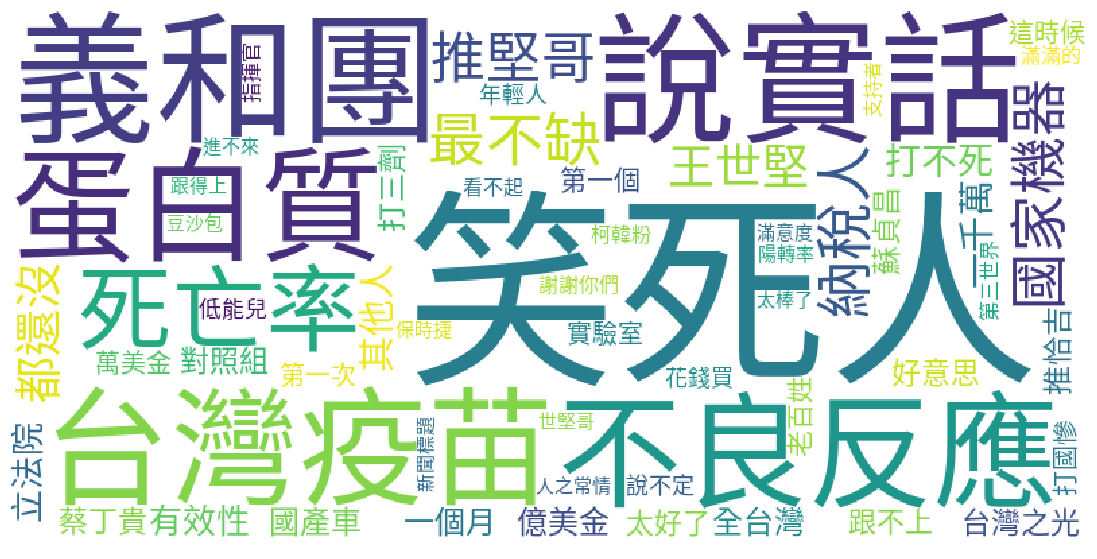

In [215]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(neg_0610_count['word'], neg_0610_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-08-16  (開放「高端」（Medigen）的接種線上預約。)

In [216]:
# 幫每句話加上情緒分數
data_0816= data_orig[data_orig['artDate'] == '2021-08-16']
data_0816['sentimentValue'] = data_0816.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
data_0816.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


artDate                                             artUrl  \
17665 2021-08-16  https://www.ptt.cc/bbs/Gossiping/M.1629072651....   
17666 2021-08-16  https://www.ptt.cc/bbs/Gossiping/M.1629075922....   
17667 2021-08-16  https://www.ptt.cc/bbs/Gossiping/M.1629076224....   
17668 2021-08-16  https://www.ptt.cc/bbs/Gossiping/M.1629076624....   
17669 2021-08-16  https://www.ptt.cc/bbs/Gossiping/M.1629077111....   

                                                sentence  sentimentValue  
17665  媒體來源自由記者署名即時新聞綜合報導通篇無記者敢署名完整新聞標題事件陳其邁成大贏家完整新聞內...        0.000000  
17666  媒體來源中時新聞網記者署名莊雅婷完整新聞標題游淑慧曝成官員已打疫苗覆蓋率勝長輩怒問年輕人該討...        0.000000  
17667  備註請放最後面違者新聞文章刪除媒體來源蘋果日報記者署名黃仲丘林芳如完整新聞標題獨家高端打完換...        0.000000  
17668  又到了飢餓行銷的時候各位覺青最期待的高端要來了緊張嗎興奮嗎電腦準備好了沒準備開搶預約了嗎有八...        0.000005  
17669  如題問看到板上大家都想打莫德納好像是當年大家都在追的班花一樣不禁讓我思考如果莫德納是班花那高...        0.006892

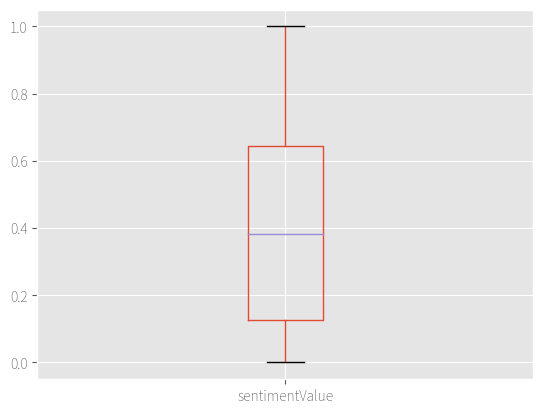

In [217]:
data_0816.boxplot(column=['sentimentValue'], showfliers=True)

### 正面句子或文章的用詞

In [225]:
pos_0816 = data_0816.loc[data_0816['sentimentValue'] >= 0.7]
pos_0816 = pd.merge(pos_0816,data[data['artDate']=='20210816'][['artUrl','word']],on='artUrl',how='left')
pos_0816 = pos_0816[['artDate','sentimentValue','word']]
pos_0816_count = pos_0816.groupby('word').size().reset_index(name='size')
pos_0816_count = pos_0816_count[[(len(w)>2 and w not in stopWords) for w in pos_0816_count['word']]]

In [227]:
pos_0816_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
pos_0816_count = pos_0816_count[pos_0816_count['size']>1000 ]  #過濾出現太少次的字
pos_0816_count.head(5)

word  size
3141   年輕人  9558
5761  生日快樂  8930
5132   民進黨  4758
6970   莫德納  4060
2009   哈哈哈  3805

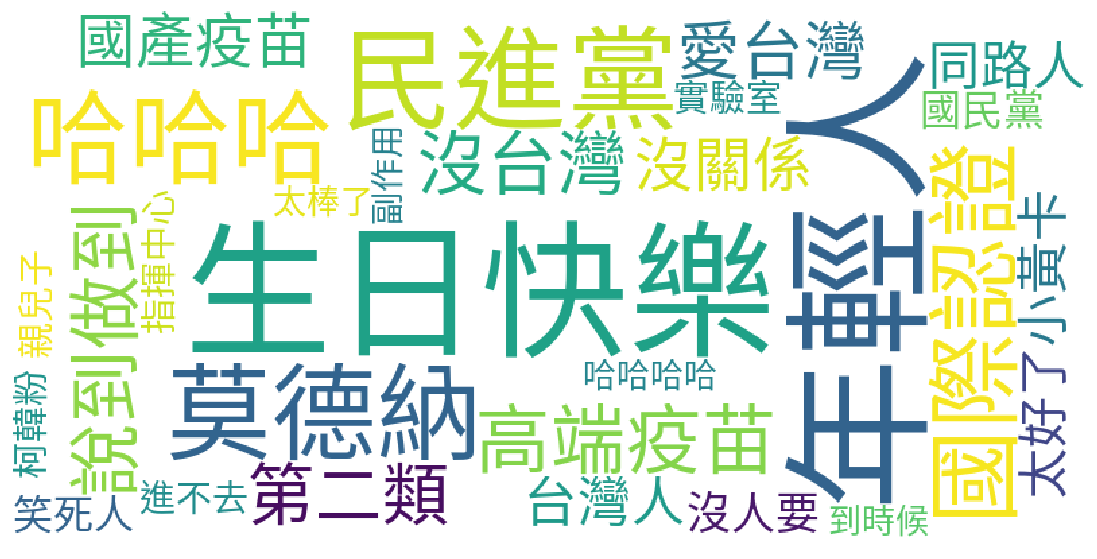

In [228]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(pos_0816_count['word'], pos_0816_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 負面句子或文章的用詞

In [231]:
neg_0816 = data_0816.loc[data_0816['sentimentValue'] <= 0.4]
neg_0816 = pd.merge(neg_0816,data[data['artDate']=='20210816'][['artUrl','word']],on='artUrl',how='left')
neg_0816 = neg_0816[['artDate','sentimentValue','word']]
neg_0816_count = neg_0816.groupby('word').size().reset_index(name='size')
neg_0816_count = neg_0816_count[[(len(w)>2 and w not in stopWords) for w in neg_0816_count['word']]]

In [234]:
neg_0816_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
neg_0816_count = neg_0816_count[neg_0816_count['size']>1000 ]  #過濾出現太少次的字
neg_0816_count = neg_0816_count[neg_0816_count['size']<10000 ]
neg_0816_count.head(5)

word  size
7533  說到做到  9636
5247   沒台灣  8944
9069  高端疫苗  8922
2268  國際認證  7312
6354   第二類  7030

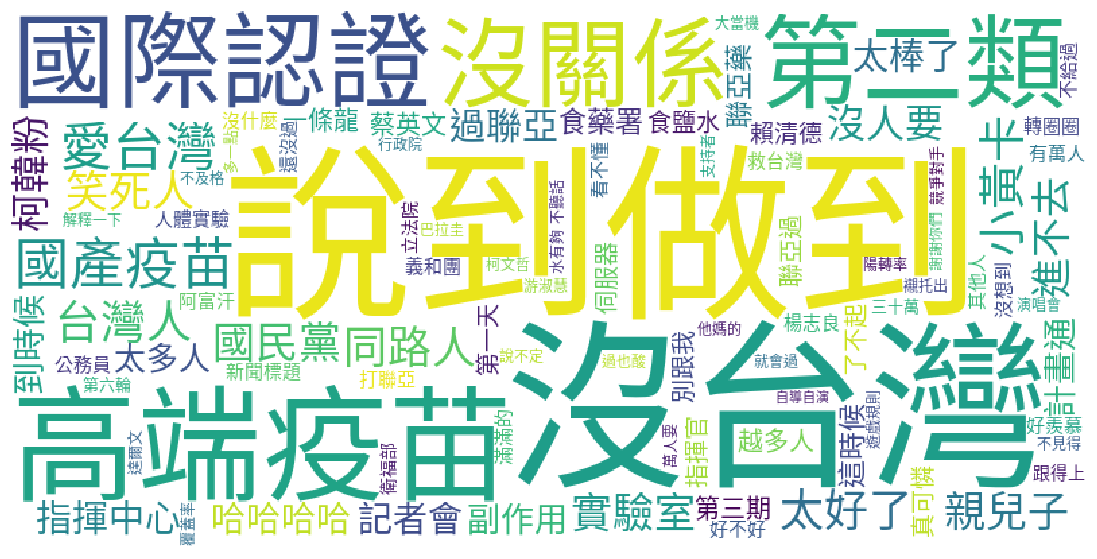

In [235]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(neg_0816_count['word'], neg_0816_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-11-12 (打高端想出國｢要混打2劑國際疫苗｣)

In [236]:
# 幫每句話加上情緒分數
data_1112= data_orig[data_orig['artDate'] == '2021-11-12']
data_1112['sentimentValue'] = data_1112.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
data_1112.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


artDate                                             artUrl  \
26944 2021-11-12  https://www.ptt.cc/bbs/Gossiping/M.1636689333....   
26945 2021-11-12  https://www.ptt.cc/bbs/Gossiping/M.1636690769....   
26946 2021-11-12  https://www.ptt.cc/bbs/Gossiping/M.1636693231....   
26947 2021-11-12  https://www.ptt.cc/bbs/Gossiping/M.1636697466....   
26948 2021-11-12  https://www.ptt.cc/bbs/Gossiping/M.1636697683....   

                                                sentence  sentimentValue  
26944  很意外嗎試算一下必要開銷不就知道了以一家口養到大學畢業計算育嬰時期的各種尿布奶粉副食品花費學...    1.773914e-12  
26945  董中潭生地學影是圈台平我越來越相信兩件事抗中保台都是假的護航高端是真的這種台面上吵架台面下唱...    2.993688e-01  
26946  下面這種論述實在讓人忍不住想問其人究竟是那個學校的碩博士還是學士又或沒念過什麼書的阿魯若是阿...    2.220446e-16  
26947  陳時中記者會宣布有出國需求的民眾已經施打高端疫苗間隔天後可以混打國際疫苗所以高端是白打了嗎還...    2.791522e-03  
26948  安安大家豪我城武辣之前一堆高端仔充滿信仰的去打高端現在看到國外經過三期檢驗認證合格的疫苗都可...    2.331714e-05

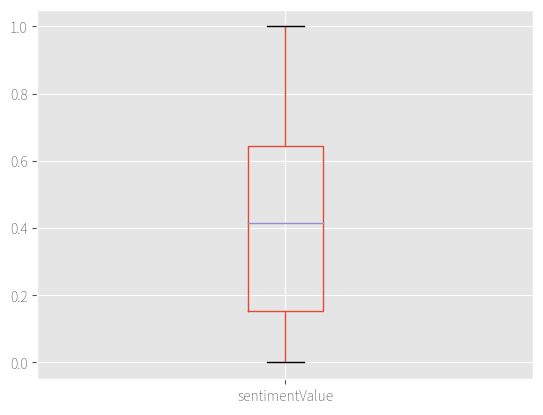

In [237]:
data_1112.boxplot(column=['sentimentValue'], showfliers=True)

### 正面句子或文章的用詞

In [241]:
pos_1112 = data_1112.loc[data_1112['sentimentValue'] >= 0.7]
pos_1112 = pd.merge(pos_1112,data[data['artDate']=='20211112'][['artUrl','word']],on='artUrl',how='left')
pos_1112 = pos_1112[['artDate','sentimentValue','word']]
pos_1112_count = pos_1112.groupby('word').size().reset_index(name='size')
pos_1112_count = pos_1112_count[[(len(w)>2 and w not in stopWords) for w in pos_1112_count['word']]]

In [242]:
pos_1112_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
pos_1112_count = pos_1112_count[pos_1112_count['size']>500 ]  #過濾出現太少次的字
pos_1112_count = pos_1112_count[pos_1112_count['size']<4500 ]
pos_1112_count.head(5)

word  size
4714   蔡英文  3972
1353  哈哈哈哈  3368
5887   食鹽水  3348
5940  高端疫苗  3056
1249   台灣人  2917

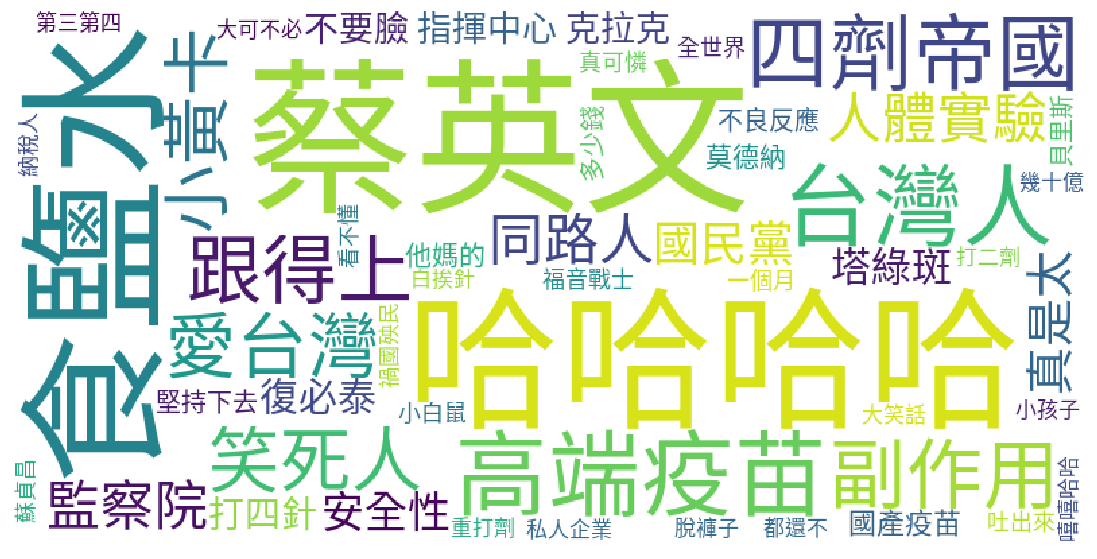

In [243]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(pos_1112_count['word'], pos_1112_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 負面句子或文章的用詞

In [247]:
neg_1112 = data_1112.loc[data_1112['sentimentValue'] <= 0.4]
neg_1112 = pd.merge(neg_1112,data[data['artDate']=='20211112'][['artUrl','word']],on='artUrl',how='left')
neg_1112 = neg_1112[['artDate','sentimentValue','word']]
neg_1112_count = neg_1112.groupby('word').size().reset_index(name='size')
neg_1112_count = neg_1112_count[[(len(w)>2 and w not in stopWords) for w in neg_1112_count['word']]]

In [248]:
neg_1112_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
neg_1112_count = neg_1112_count[neg_1112_count['size']>1000 ]  #過濾出現太少次的字
neg_1112_count.head(5)

word   size
1400   哈哈哈  14329
3553   民進黨  13794
4470   納稅錢  12452
1605  國際認證  12262
3376   柯文哲  10562

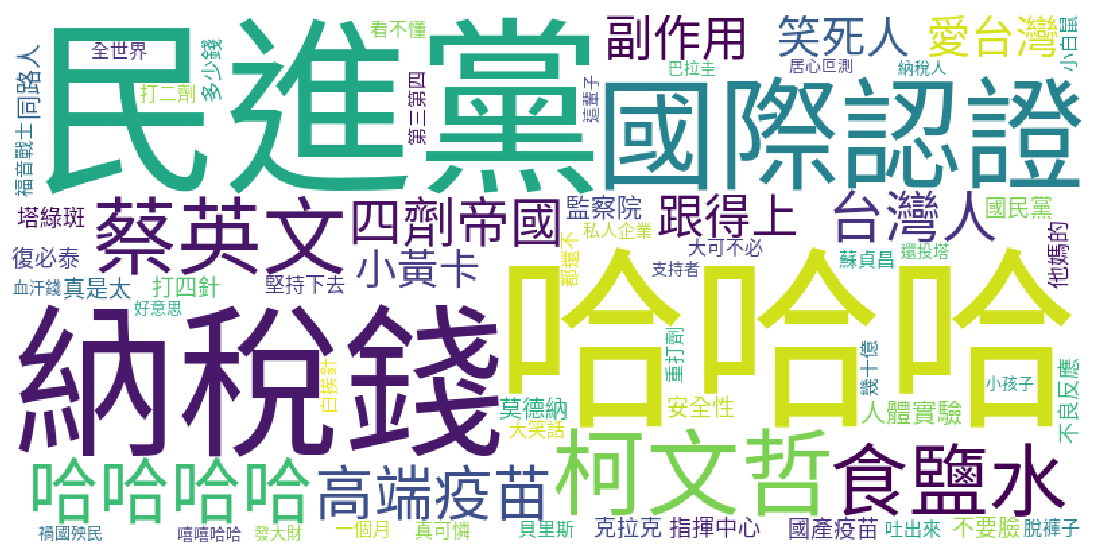

In [249]:
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict(zip(neg_1112_count['word'], neg_1112_count['size'])))
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

## 5 N-gram

### 5.1 根據不同時期建立Ngram預測模型並且 Bigram視覺化 

- 最後我們將資料切分成三個時期，分別是 **<font>2020/02/01 ~ 2020/12/31</font>** , **<font>2021/01/01 ~ 2021/05/30</font>**以及 **<font>2021/05/31 ~ 2021/11/19</font>**，以上三個時期分別代表著高端疫苗研發且剛推出的初期，高端疫苗正式推入市場的中期，以及高端疫苗備受爭議的末期。
- 藉由建立 Bigram model 我們想知道在不同的時期，**<font>對於「高端」或是「高端疫苗」等字詞，將會預測出哪些字詞</font>**。

In [140]:
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [55]:
data1 = MetaData[(MetaData['artDate']<='2020/12/31')]
data2 = MetaData[(MetaData['artDate']>='2021/01/01') & (MetaData['artDate']<='2021/05/30')]
data3 = MetaData[(MetaData['artDate']>='2020/05/31')]

In [56]:
token1 = data1.sentence.apply(getToken).tolist()
token2 = data2.sentence.apply(getToken).tolist()
token3 = data3.sentence.apply(getToken).tolist()

In [58]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [60]:
bi_prediction1 = ngram(token1, N=2)
bi_prediction2 = ngram(token2, N=2)
bi_prediction3 = ngram(token3, N=2)

### 2020/02/01 ~ 2020/12/31 (高端疫苗初期)

In [87]:
text = '高端疫苗'
next_words = list(bi_prediction1[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 公司, probability: 0.25
next word: 亞諾, probability: 0.0625
next word: 總經理, probability: 0.0625
next word: 合作, probability: 0.0469
next word: 生物製劑, probability: 0.0469


In [ ]:
bigramfdist = FreqDist()
data1_bigram = data1.copy()
data1_bigram["word"] = data1_bigram.sentence.apply(bigram_getToken_dict)
data1_bigram = data1_bigram.explode('word')

In [123]:
d = {k:v for k,v in bigramfdist.most_common(20)}
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.03 for w in  G.edges(data=True)]

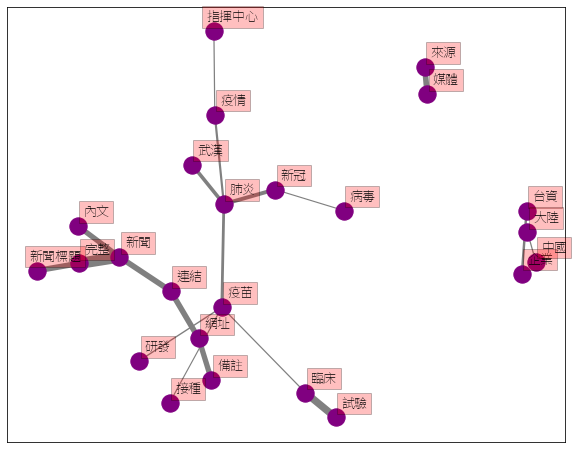

In [125]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

由 Bigram 以及視覺化的結果可以看出，在 2020 年整年對於高端疫苗的討論度是較低的，縱使我們已經以"高端疫苗"當作關鍵詞篩選出特定的文章，但從結果還是可以看出:此時的討論大多圍繞在新冠肺炎。

### 2021/01/01 ~ 2021/05/30 (高端疫苗中期)

In [88]:
text = '高端疫苗'
next_words = list(bi_prediction2[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 二期, probability: 0.0427
next word: 股價, probability: 0.032
next word: 聯亞, probability: 0.0249
next word: 生物製劑, probability: 0.0214
next word: 三期, probability: 0.0178


In [155]:
bigramfdist = FreqDist()
data2_bigram = data2.copy()
data2_bigram["word"] = data2_bigram.sentence.apply(bigram_getToken_dict)
data2_bigram = data2_bigram.explode('word')

In [156]:
d = {k:v for k,v in bigramfdist.most_common(40)}
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.03 for w in  G.edges(data=True)]

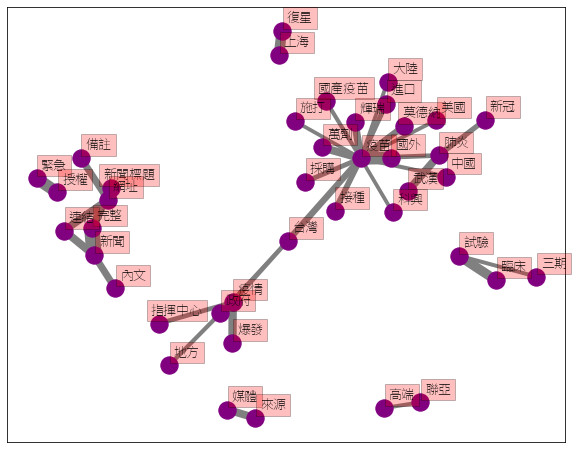

In [157]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

到了歷程的中期之後，討論的主軸從新冠肺炎逐漸轉向疫情的爆發以及疫苗的接種，此時可以看出:國產疫苗、試驗臨床三期、以及緊急授權等等關鍵字詞，說明此時對於高端疫苗的討論度已經逐漸上升。

### 2021/05/31 ~ 2021/11/19 (高端疫苗後期)

In [91]:
text = '高端疫苗'
next_words = list(bi_prediction3[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 二期, probability: 0.0181
next word: 開打, probability: 0.015
next word: </s>, probability: 0.0137
next word: 預約, probability: 0.0135
next word: 緊急, probability: 0.0133


In [144]:
bigramfdist = FreqDist()
data3_bigram = data3.copy()
data3_bigram["word"] = data3_bigram.sentence.apply(bigram_getToken_dict)
data3_bigram = data3_bigram.explode('word')

In [151]:
d = {k:v for k,v in bigramfdist.most_common(40)}
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

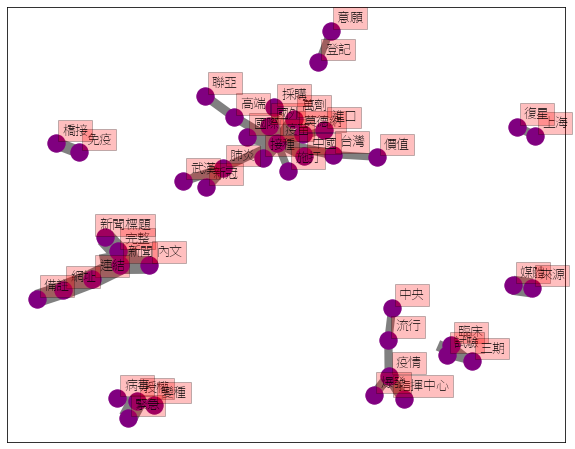

In [152]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

- 最後讓我們比較驚訝的事情是，事件末期竟然沒有出現任何一個謾罵性的詞彙，但從以上的結果還是可以看到高端、台灣價值、登記意願等等字詞，說明大多數人對於高端疫苗的不信任以及嘲諷。
- 值得一提的是，比起歷程的中期，高端、莫德納等等跟疫苗相關的詞其關係更加緊密，
- 到了事件後期相關的文章都會著眼於這些議題，表示人們對於疫苗接種的選擇以及對國產疫苗有更多的討論。

## 結論
+ 負面情緒起伏大致可以對照高端疫苗的重大事件。可見大家關注於疫苗議題。
+ 使用結巴做的情緒分析在正面、負面用詞上在四個日期上沒有明顯差異。
+　透過SnowNLP所產生的盒狀圖能以圖像、直觀地了解該議題的情緒分布
+ SnowNLP的情緒分析結果為負面，我們認為以SnowNLP做分析比較適合，因為在結巴的斷詞中可能忽略整個句子的語意。
+ N-gram 的分析結果令我們驚訝，沒有出現任何一個謾罵性的詞彙，我們在仔細思考，其實這樣的結果較直觀，顯示大家對於這些議題，著重在疫苗接種的選擇和關注於指揮中心的政策上。
+ PTT分析僅能得知文章的情緒分布，並不能得知其發文的意圖，因此僅為參考用。還是要留意帶風向、網軍的情形發生。
### 未來展望
+ 我們覺得之後可以加上前後句作情緒分析，在正負面情緒的判斷上可能會更好。